# Projet Data Mining

## 1. Collecte de donn√©es

Collection et t√©l√©chargement d'un ensemble d'images et automatisation le processus autant que possible 

Les t√¢ches :
 
1.  Cr√©er un dossier appel√© *images*.
2.  T√©l√©charger les images sous licence ouverte dans le dossier *images* (minimum 100
    images).
3.  Enregistrez les m√©tadonn√©es de chaque image comme la taille de l'image, le format de l'image (.jpeg,
    .png, etc.), l'orientation de l'image (paysage, portrait, carr√©, etc.),
    date de cr√©ation, mod√®le d'appareil photo, etc. dans un ou plusieurs fichiers JSON. Vous pouvez utiliser les informations [Exif](https://en.wikipedia.org/wiki/Exif) pr√©sentes dans les fichiers d'images.

In [1]:
!pip install requests pillow

In [ ]:
import json
import os
from urllib.parse import urlparse
import requests


def get_nasa_images(query, count=10):
    """R√©cup√®re les m√©tadonn√©es des images de l'API de la NASA"""
    print(f"Recherche de {count} images li√©es √† '{query}'...")
    url = f"https://images-api.nasa.gov/search?q={query}&media_type=image&page=1&page_size={count}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Erreur : Impossible de se connecter √† l'API de la NASA (Code {response.status_code})")
        return []
    
    data = response.json()
    
    if 'collection' not in data or 'items' not in data['collection']:
        print("Erreur : Format de r√©ponse inattendu ou aucun r√©sultat trouv√©")
        return []
    
    results = []
    for item in data['collection']['items']:
        try:
            # Extraire les m√©tadonn√©es de base
            image_data = {
                'title': item['data'][0]['title'],
                'description': item['data'][0]['description'],
                'date_created': item['data'][0]['date_created'],
                'nasa_id': item['data'][0]['nasa_id'],
                'image_url': item['links'][0]['href'] if 'links' in item else None,
                'keywords': item['data'][0].get('keywords', []),
                'center': item['data'][0].get('center', 'Inconnu'),
                'year': item['data'][0]['date_created'][:4] if 'date_created' in item['data'][0] else 'Inconnu'
            }
            
            # Obtenir l'URL de l'image en haute r√©solution
            if 'nasa_id' in image_data and image_data['nasa_id']:
                asset_url = f"https://images-api.nasa.gov/asset/{image_data['nasa_id']}"
                try:
                    asset_response = requests.get(asset_url)
                    if asset_response.status_code == 200:
                        asset_data = asset_response.json()
                        if 'collection' in asset_data and 'items' in asset_data['collection']:
                            # Rechercher l'image originale ou la plus haute r√©solution disponible
                            for asset in asset_data['collection']['items']:
                                if 'orig' in asset['href'].lower() or 'original' in asset['href'].lower():
                                    image_data['hires_url'] = asset['href']
                                    break
                            # Si aucune image originale, utiliser la premi√®re disponible
                            if 'hires_url' not in image_data and asset_data['collection']['items']:
                                image_data['hires_url'] = asset_data['collection']['items'][0]['href']
                except Exception as e:
                    print(f"Erreur lors de la r√©cup√©ration de l'asset pour {image_data['nasa_id']}: {e}")
            
            results.append(image_data)
        except (KeyError, IndexError) as e:
            print(f"Erreur lors du traitement d'un √©l√©ment : {e}")
            continue
    
    print(f"{len(results)} images trouv√©es pour '{query}'")
    return results

def save_to_json(data, filename):
    """Sauvegarde les donn√©es dans un fichier JSON"""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Donn√©es sauvegard√©es dans {filename}")

def main():
    # D√©finir les r√©pertoires
    base_dir = "astronomy_dataset"
    metadata_dir = os.path.join(base_dir, "metadata")
    images_dir = os.path.join(base_dir, "images")
    
    # Cr√©er les r√©pertoires s'ils n'existent pas
    os.makedirs(metadata_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)
    
    # Liste des cat√©gories astronomiques √† rechercher
    categories = {
        "planet": 15,
        "galaxy": 15,
        "star": 15,
        "nebula": 15,
        "asteroid": 10,
        "supernova": 10,
        "black hole": 10,
        "pulsar": 10,
        "moon": 10,
        "jupiter": 5,
        "saturn": 5,
        "mars": 5
    }
    
    # Collection compl√®te pour toutes les cat√©gories
    all_images = {}
    
    # R√©cup√©rer les images pour chaque cat√©gorie
    for category, count in categories.items():
        print(f"\n{'='*60}")
        print(f" TRAITEMENT DE LA CAT√âGORIE : {category.upper()} ")
        print(f"{'='*60}")
        
        # Cr√©er un r√©pertoire pour cette cat√©gorie
        category_dir = os.path.join(images_dir, category.replace(' ', '_'))
        os.makedirs(category_dir, exist_ok=True)
        
        # Obtenir les m√©tadonn√©es
        images_data = get_nasa_images(category, count)
        
        # Ajouter les donn√©es √† la collection globale
        all_images[category] = images_data
    
    # Sauvegarder toutes les donn√©es en JSON
    save_to_json(all_images, os.path.join(metadata_dir, "nasa_images.json"))
    
if __name__ == "__main__":
    main()



 TRAITEMENT DE LA CAT√âGORIE : PLANET 
Recherche de 15 images li√©es √† 'planet'...
15 images trouv√©es pour 'planet'

 TRAITEMENT DE LA CAT√âGORIE : GALAXY 
Recherche de 15 images li√©es √† 'galaxy'...
15 images trouv√©es pour 'galaxy'

 TRAITEMENT DE LA CAT√âGORIE : STAR 
Recherche de 15 images li√©es √† 'star'...
15 images trouv√©es pour 'star'

 TRAITEMENT DE LA CAT√âGORIE : NEBULA 
Recherche de 15 images li√©es √† 'nebula'...
15 images trouv√©es pour 'nebula'

 TRAITEMENT DE LA CAT√âGORIE : ASTEROID 
Recherche de 10 images li√©es √† 'asteroid'...
10 images trouv√©es pour 'asteroid'

 TRAITEMENT DE LA CAT√âGORIE : SUPERNOVA 
Recherche de 10 images li√©es √† 'supernova'...
10 images trouv√©es pour 'supernova'

 TRAITEMENT DE LA CAT√âGORIE : BLACK HOLE 
Recherche de 10 images li√©es √† 'black hole'...
10 images trouv√©es pour 'black hole'

 TRAITEMENT DE LA CAT√âGORIE : PULSAR 
Recherche de 10 images li√©es √† 'pulsar'...
10 images trouv√©es pour 'pulsar'

 TRAITEMENT DE LA CAT√âGOR

## 2. √âtiquetage et annotation

Cette t√¢che, concerne la recherche les sources disposant d'informations suppl√©mentaires comme les balises, les cat√©gories, etc. Le but c'est: 

1. √âtiqueter, annoter et enregistrer des informations sur chaque image. 
2. Analyser les images en utilisant des algorithmes de regroupement pour trouver les couleurs pr√©dominantes.

Disposant d√©j√† de certaines m√©tadonn√©es provenant de l'EXIF des images de la pr√©c√©dente t√¢che. Dans cette t√¢che, l'objectif est d'obtenir des informations suppl√©mentaires, comme les couleurs pr√©dominantes, les tags. 

### Questions:

1. Et si vous demandiez aux utilisateurs de tagger les images ? Par exemple, les noms de couleurs, \#cat, \#fleur, \#sous-fleur, rose etc.

 - Certaines balises sont d√©j√† collect√©es automatiquement via le champ ¬´ mots-cl√©s ¬ª fourni par l‚ÄôAPI de la NASA. Pour permettre aux utilisateurs d‚Äôajouter leurs propres balises, une √©tape suppl√©mentaire peut √™tre mise en ≈ìuvre apr√®s le t√©l√©chargement des images et l‚Äôextraction des m√©tadonn√©es. Dans cette √©tape, les utilisateurs peuvent examiner chaque image et ajouter des balises personnalis√©es, qui seront incorpor√©es dans le champ ¬´ mots-cl√©s ¬ª des fichiers JSON g√©n√©r√©s (nasa_images.json ou extracted_metadata.json).

2. Comment pr√©voyez-vous de traiter ces tags ? Est-il possible d'automatiser ce processus ?
 
 - Le syst√®me collecte d√©j√† les tags fournis par l‚ÄôAPI, mais il existe plusieurs options pour automatiser ce processus et enrichir les tags :

 * Reconnaissance d‚Äôimages par IA :
    Un mod√®le pr√©-entra√Æn√© tel que CLIP d‚ÄôOpenAI ou Google Vision pourrait √™tre utilis√© pour identifier automatiquement les √©l√©ments visuels dans les images (par exemple, ¬´ #luna ¬ª, ¬´ #estrella ¬ª, ¬´ #rojo ¬ª).

 * Extraction d‚Äôinformations √† partir de noms de fichiers ou de dossiers :
    √âtant donn√© que les images sont d√©j√† organis√©es en dossiers par cat√©gories (telles que ¬´ galaxie ¬ª, ¬´ plan√®te ¬ª, etc.), cette structure pourrait √™tre exploit√©e pour g√©n√©rer automatiquement des balises de base.

 * Analyse des descriptions :
    Il est possible d‚Äôanalyser les descriptions fournies par l‚ÄôAPI √† l‚Äôaide de techniques de traitement du langage naturel (NLP) pour identifier les mots-cl√©s pertinents et les transformer en balises suppl√©mentaires.

In [2]:
import os
import json
from PIL import Image
from PIL.ExifTags import TAGS

# Fonction pour traduire l'orientation EXIF en "horizontal" ou "vertical"
def interpreter_orientation(value):
    orientations = {
        1: "Horizontal",
        3: "Horizontal (invers√©e)",
        6: "Vertical",
        8: "Vertical (invers√©e)"
    }
    return orientations.get(value, "Inconnue")

# R√©pertoires de base
images_dir = "astronomy_dataset/images"
metadata_dir = "astronomy_dataset/metadata"

metadata_results = []

# Parcourir r√©cursivement les dossiers d'images
for root, dirs, files in os.walk(images_dir):
    category = os.path.basename(root)  # Cat√©gorie = nom du dossier
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            try:
                # Ouvrir l'image et obtenir la taille
                img = Image.open(image_path)
                width, height = img.size
                size = {"width": width, "height": height}

                # Extraire les m√©tadonn√©es EXIF
                exif_data_raw = img._getexif()
                exif_data = {}
                orientation = "Non disponible"
                if exif_data_raw:
                    for tag, value in exif_data_raw.items():
                        tag_name = TAGS.get(tag, tag)
                        exif_data[tag_name] = value
                        # Extraire et traduire l'orientation
                        if tag_name == "Orientation":
                            orientation = interpreter_orientation(value)

                metadata_results.append({
                    "category": category,
                    "file_name": file,
                    "file_path": image_path,
                    "size": size,
                    "orientation": orientation,
                    "exif": exif_data
                })
            except Exception as e:
                print(f"Erreur lors du traitement de {image_path}: {e}")

# Sauvegarder les m√©tadonn√©es dans un fichier JSON
output_file = os.path.join(metadata_dir, "extracted_metadata.json")
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(
        metadata_results, 
        f, 
        ensure_ascii=False, 
        indent=4, 
        default=lambda o: float(o) if hasattr(o, 'numerator') else str(o)
    )

print(f"M√©tadonn√©es extraites et sauvegard√©es dans {output_file}")


M√©tadonn√©es extraites et sauvegard√©es dans astronomy_dataset/metadata\extracted_metadata.json


## 3. Analyses de donn√©es

Dans cette partie on demande √† l'utilisateur de s√©lectionner quelques images et d'ajouter des balises. Pour chaque utilisateur, sera construit un profil de pr√©f√©rences d'utilisateur, bas√© sur cette s√©lection. On peut recueillir les informations suivantes manuellement, mais l'objectif de cette t√¢che consiste √† les obtenir en utilisant les images s√©lectionn√©es de mani√®re automatis√©e : 


**1.  Couleurs pr√©f√©r√©es**

**2.  Orientation de l'image pr√©f√©r√©e**

**3.  Tailles d'images pr√©f√©r√©es (vignettes, grandes images, images de taille moyenne images, etc.)**

**4.  Balises favorites**

**5.  \...**


#### Question 1 :
 - Maintenant, gr√¢ce √† votre connaissance des diff√©rents types de classificateurs et les algorithmes de regroupement, quelles informations suppl√©mentaires ajouterez-vous pour chaque image ?

 * Un code a √©t√© mis en place pour demander √† l‚Äôutilisateur la raison de son preference.
 Celui-ci est enregistr√© dans un fichier json et est utilis√© pour filtrer les pr√©f√©rences et ne pas utiliser de donn√©es erron√©es
#### Question 2 :
 - Votre prochain objectif est d'analyser les informations des utilisateurs et leur les images pr√©f√©r√©es. Comment avez-vous cr√©√© des utilisateurs al√©atoires ? Combien d'utilisateurs avez-vous cr√©er ? Quelles informations avez-vous stock√©es pour chaque utilisateur ? Quels types d'analyses avez-vous effectu√©es ?

 * Les utilisateurs ne sont pas al√©atoires, 5 utilisateurs ont √©t√© cr√©√©s via une interface graphique, o√π chacun a enregistr√© son nom et ses pr√©f√©rences d‚Äôimage. L‚Äôanalyse n‚Äôa pas √©t√© effectu√©e en fonction des pr√©f√©rences de chaque utilisateur, mais sur le nombre total d‚Äôimages t√©l√©charg√©es, qui ont √©t√© divis√©es par cat√©gorie.

In [3]:
import os
import json
import tkinter as tk
from tkinter import ttk, Scrollbar, Frame, simpledialog
from PIL import Image, ImageTk

# Chemin de base o√π se trouvent les images
IMAGE_FOLDER = "astronomy_dataset/images/"
USER_FOLDER = "usuarios/"
METADATA_FILE = "astronomy_dataset/metadata/extracted_metadata.json"

# Cr√©er le dossier des utilisateurs s'il n'existe pas
os.makedirs(USER_FOLDER, exist_ok=True)

# Charger les m√©tadonn√©es √† partir du fichier JSON
with open(METADATA_FILE, "r") as f:
    metadata = json.load(f)

def get_metadata_for_image(image_name):
    """Buscar metadatos para una imagen espec√≠fica"""
    for item in metadata:
        if item["file_name"] == image_name:
            return item
    return None

class ImageGalleryApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Profil de Pr√©f√©rences d'Images d'Astronomie")

        # Section utilisateur
        self.user_label = ttk.Label(root, text="Utilisateur :")
        self.user_label.grid(row=0, column=0, padx=5, pady=5)

        self.user_entry = ttk.Entry(root)
        self.user_entry.grid(row=0, column=1, padx=5, pady=5)

        self.start_button = ttk.Button(root, text="D√©marrer", command=self.load_categories)
        self.start_button.grid(row=0, column=2, padx=5, pady=5)

        # Liste des cat√©gories
        self.category_listbox = tk.Listbox(root, selectmode=tk.SINGLE)
        self.category_listbox.grid(row=1, column=0, padx=5, pady=5, rowspan=5)
        self.category_listbox.bind("<<ListboxSelect>>", self.load_images)

        # Cadre contenant la galerie avec d√©filement
        self.gallery_frame = Frame(root)
        self.gallery_frame.grid(row=1, column=1, padx=5, pady=5, columnspan=2)

        self.image_canvas = tk.Canvas(self.gallery_frame, width=600, height=400, bg="white")
        self.scroll_y = Scrollbar(self.gallery_frame, orient="vertical", command=self.image_canvas.yview)
        self.scroll_x = Scrollbar(self.gallery_frame, orient="horizontal", command=self.image_canvas.xview)

        self.image_frame = Frame(self.image_canvas)
        self.image_canvas.create_window((0, 0), window=self.image_frame, anchor="nw")

        self.image_canvas.config(yscrollcommand=self.scroll_y.set, xscrollcommand=self.scroll_x.set)

        self.image_canvas.grid(row=0, column=0)
        self.scroll_y.grid(row=0, column=1, sticky="ns")
        self.scroll_x.grid(row=1, column=0, sticky="ew")

        self.image_labels = []  # Liste des widgets pour afficher les images
        self.image_buttons = {}  # Dictionnaire pour stocker les boutons "J'aime"

    def load_categories(self):
        """Charge les cat√©gories √† partir des dossiers d'images."""
        self.category_listbox.delete(0, tk.END)
        if os.path.exists(IMAGE_FOLDER):
            categories = [d for d in os.listdir(IMAGE_FOLDER) if os.path.isdir(os.path.join(IMAGE_FOLDER, d))]
            for category in categories:
                self.category_listbox.insert(tk.END, category)

    def load_images(self, event):
        """Charge les images de la cat√©gorie s√©lectionn√©e."""
        selected_category = self.category_listbox.get(tk.ACTIVE)
        category_path = os.path.join(IMAGE_FOLDER, selected_category)

        if os.path.exists(category_path):
            image_files = [f for f in os.listdir(category_path) if f.endswith((".jpg", ".png"))]
            self.display_images(image_files, category_path)

    def display_images(self, image_files, folder_path):
        """Affiche les images dans la galerie avec d√©filement."""
        for widget in self.image_frame.winfo_children():
            widget.destroy()
        self.image_labels.clear()
        self.image_buttons.clear()

        x, y = 10, 10  # Position initiale
        max_width = 180  # Largeur des miniatures
        max_height = 180  # Hauteur des miniatures
        padding = 10  # Espacement entre les images

        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            img = Image.open(image_path)
            img.thumbnail((max_width, max_height))
            img = ImageTk.PhotoImage(img)

            frame = tk.Frame(self.image_frame)
            frame.grid(row=y // (max_height + padding), column=x // (max_width + padding), padx=5, pady=5)

            image_label = tk.Label(frame, image=img)
            image_label.image = img  # Conserver la r√©f√©rence
            image_label.pack()

            like_button = ttk.Button(frame, text="J'aime", command=lambda path=image_path: self.like_image(path, image_file))
            like_button.pack()

            self.image_labels.append(image_label)
            self.image_buttons[image_path] = like_button

            x += max_width + padding
            if x > 550:  # Passe √† la ligne suivante si la largeur est d√©pass√©e
                x = 10
                y += max_height + padding

        self.image_frame.update_idletasks()
        self.image_canvas.config(scrollregion=self.image_canvas.bbox("all"))

    def like_image(self, image_path, image_name):
        """Enregistre l'image marqu√©e comme "J'aime" dans un fichier JSON avec une raison."""
        user = self.user_entry.get()
        if not user:
            print("Veuillez entrer un utilisateur.")
            return

        reason = simpledialog.askstring("Qu‚Äôavez-vous aim√©?", "Pourquoi aimez-vous cette image ?", initialvalue="couleur")
        if reason not in ["couleur", "cat√©gorie", "size"]:
            print("Veuillez choisir entre : couleur, cat√©gorie, size.")
            return

        metadata = get_metadata_for_image(image_name)
        if metadata:
            print(f"Metadata pour {image_name}:")
            print(json.dumps(metadata, indent=4))
        else:
            print("M√©tadonn√©es non disponibles pour cette image.")

        data = self.load_user_preferences(user)
        if image_path not in [item["path"] for item in data["likes"]]:
            data["likes"].append({"path": image_path, "reason": reason})

        self.save_user_preferences(user, data)

    def save_user_preferences(self, user, data):
        """Enregistre les pr√©f√©rences de l'utilisateur dans un fichier JSON."""
        user_file = os.path.join(USER_FOLDER, f"{user}.json")
        with open(user_file, "w") as f:
            json.dump(data, f, indent=4)

    def load_user_preferences(self, user):
        """Charge les pr√©f√©rences de l'utilisateur √† partir d'un fichier JSON."""
        user_file = os.path.join(USER_FOLDER, f"{user}.json")
        if os.path.exists(user_file):
            with open(user_file, "r") as f:
                return json.load(f)
        return {"likes": []}

if __name__ == "__main__":
    root = tk.Tk()
    app = ImageGalleryApp(root)
    root.mainloop()




Veuillez choisir entre : couleur, cat√©gorie, size.


## 4. Visualisation des donn√©es

Dans cette t√¢che, l'objectif est de visualiser les diff√©rentes caract√©ristiques de
toutes les images t√©l√©charg√©es.

**1.  Le nombre d'images disponibles pour chaque ann√©e**

**2.  Le nombre d'images disponibles pour les diff√©rents types : taille de l'image, l'orientation des images, les mod√®les d'appareils photo, etc.**

**3.  Caract√©ristiques des couleurs**

Les utilisateurs peuvent √©galement visualiser les informations ci-dessus relatives √† leurs images pr√©f√©r√©es. Dans cette t√¢che, on ajoute une fonctionnalit√© permettant aux utilisateurs de visualiser les informations li√©es √† leur propre profil d'utilisateur.

### 4.1. Le Nombre  d'images disponibles pour chaque ann√©e

In [3]:
!pip install seaborn


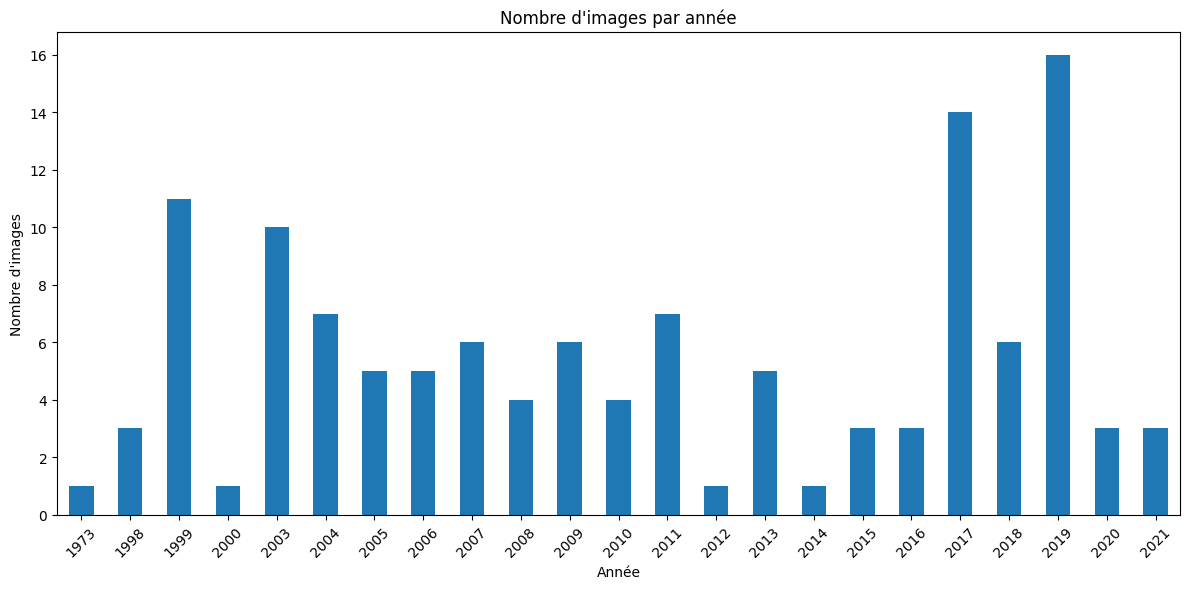


Statistiques de la collection :
Nombre total d'images : 125

Images par ann√©e :
year
1973     1
1998     3
1999    11
2000     1
2003    10
2004     7
2005     5
2006     5
2007     6
2008     4
2009     6
2010     4
2011     7
2012     1
2013     5
2014     1
2015     3
2016     3
2017    14
2018     6
2019    16
2020     3
2021     3
Name: count, dtype: int64

Images par cat√©gorie :
category
planet        15
galaxy        15
star          15
nebula        15
asteroid      10
supernova     10
black hole    10
pulsar        10
moon          10
jupiter        5
saturn         5
mars           5
Name: count, dtype: int64


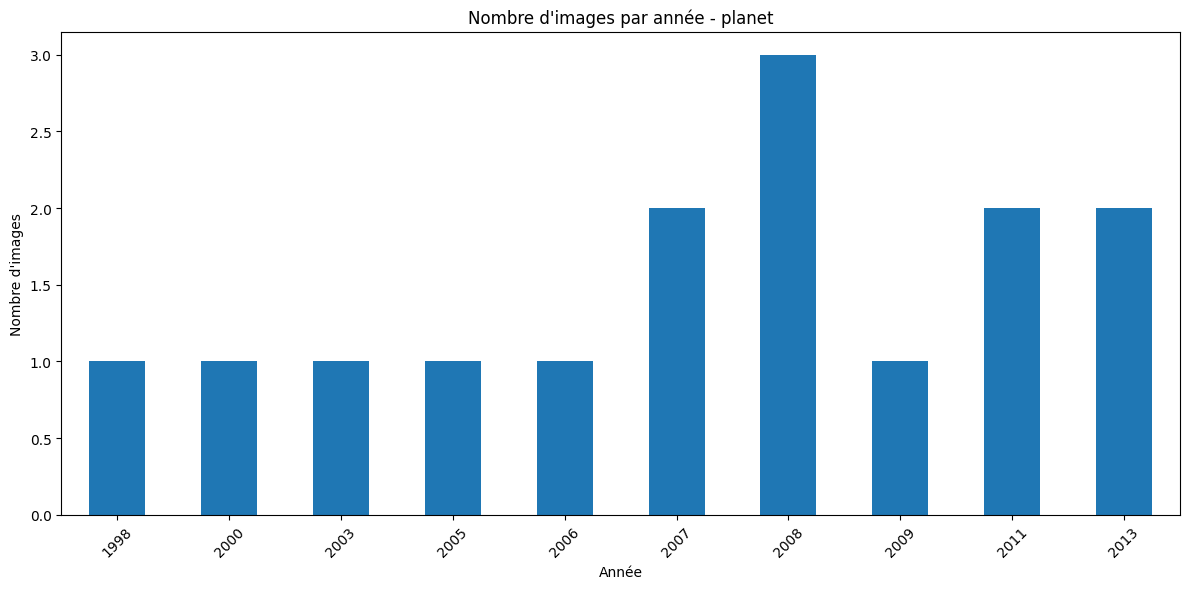

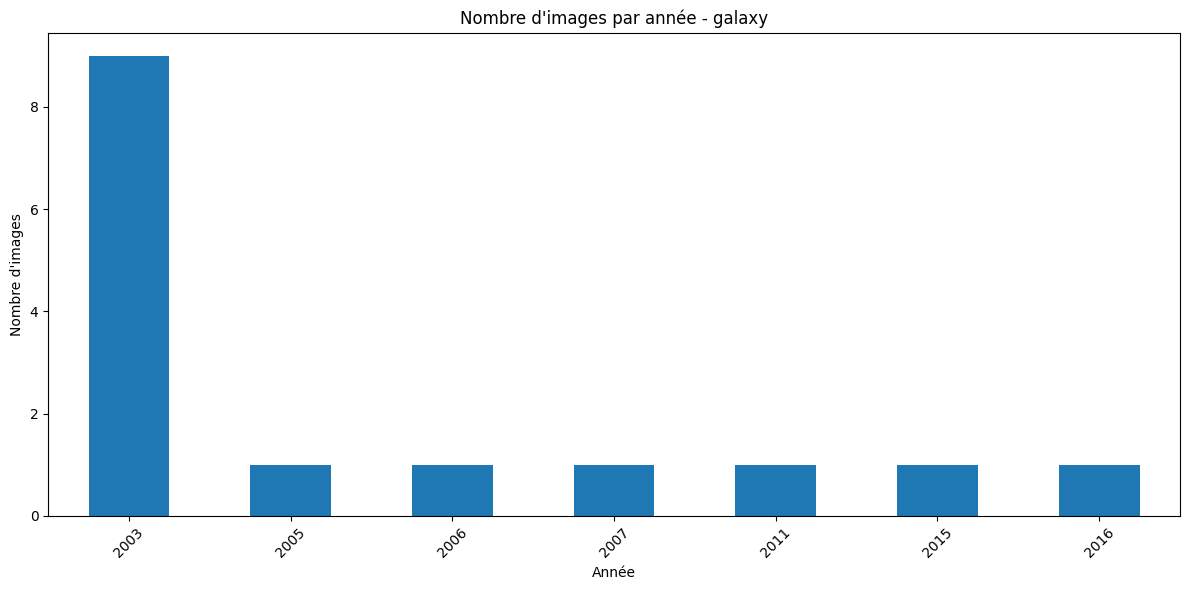

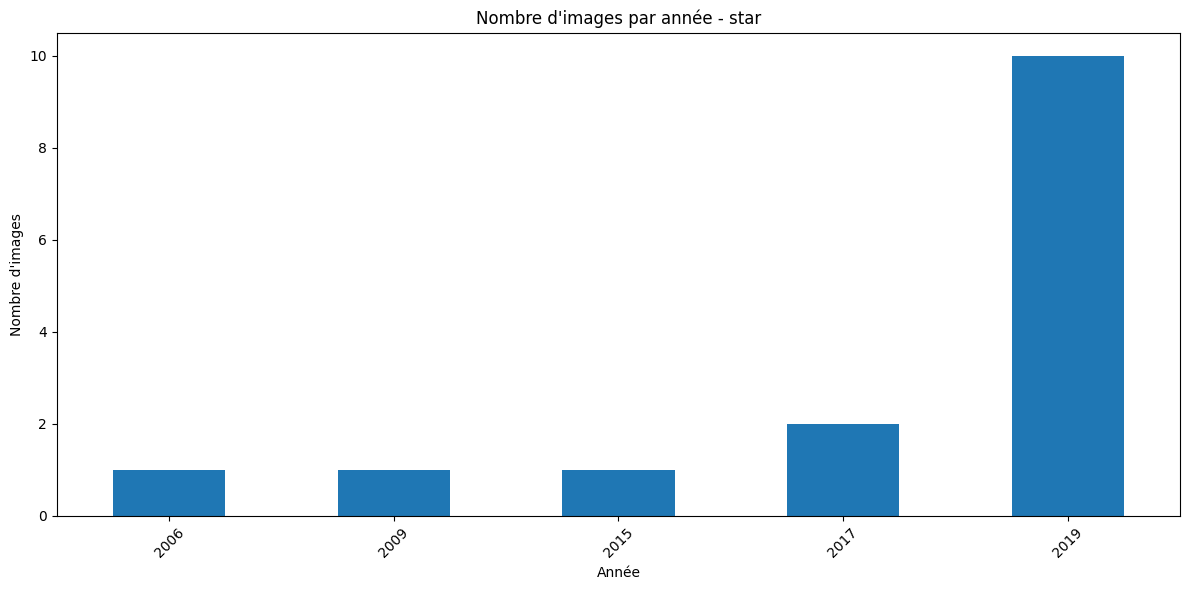

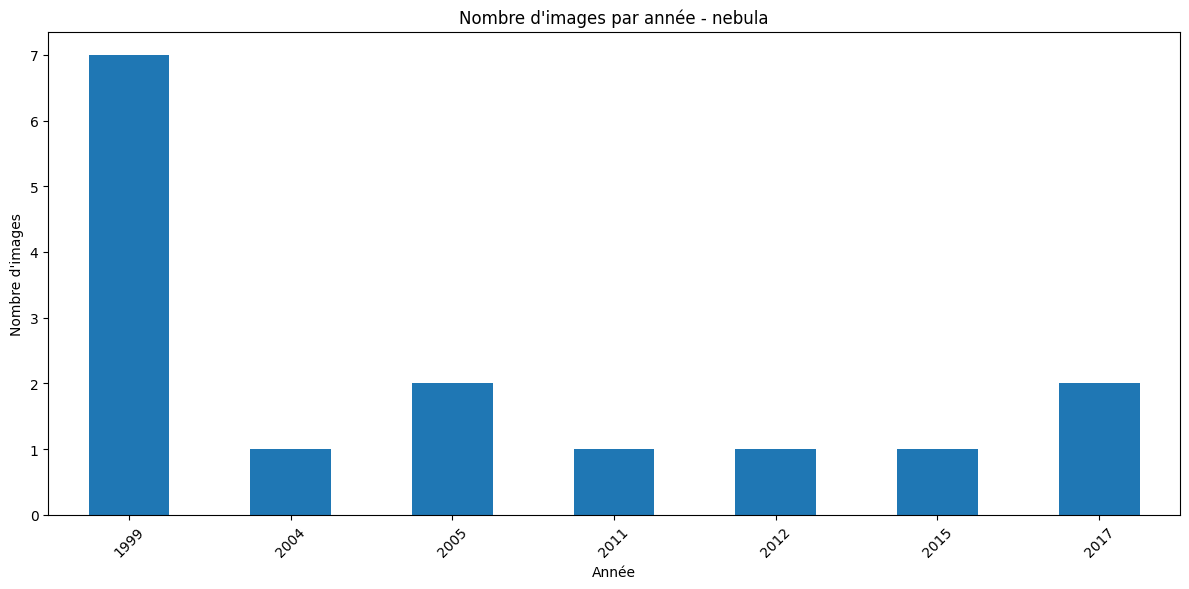

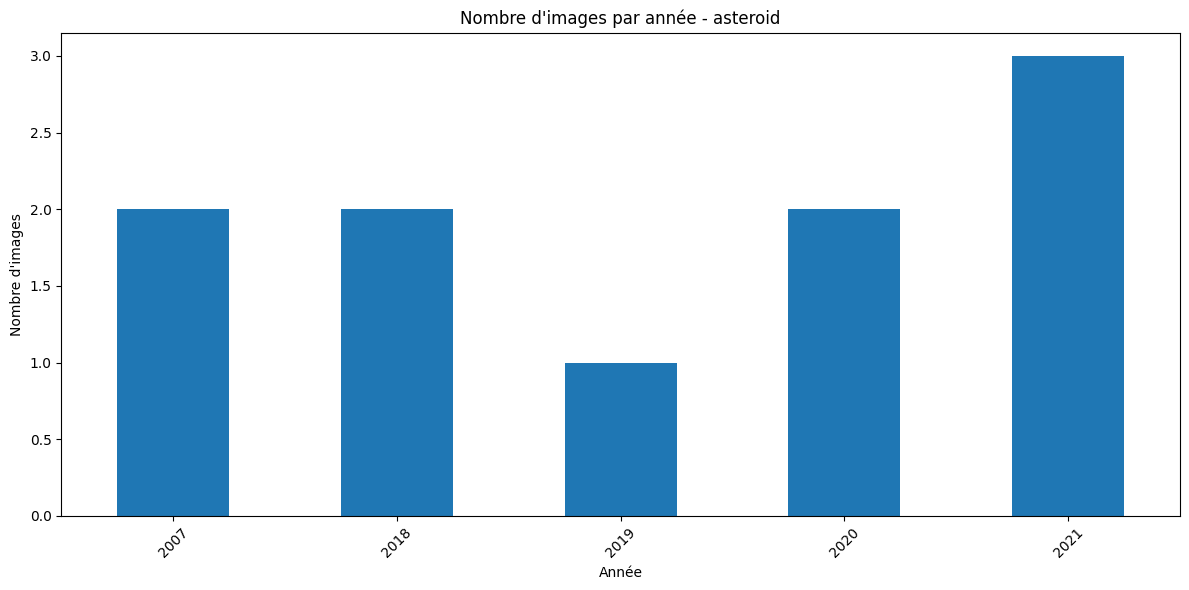

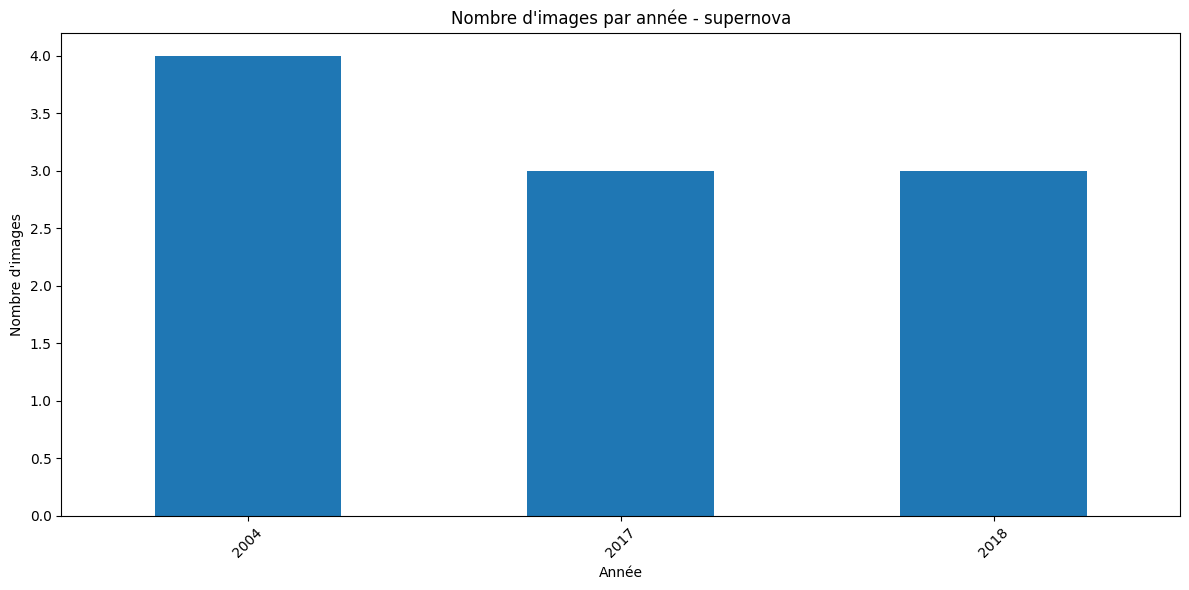

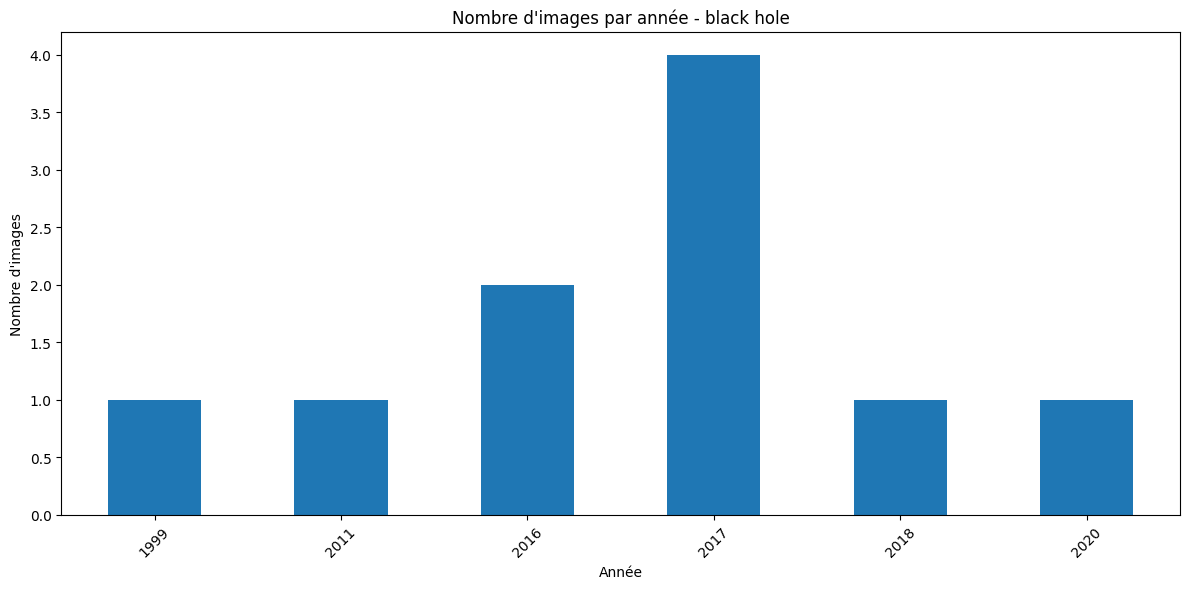

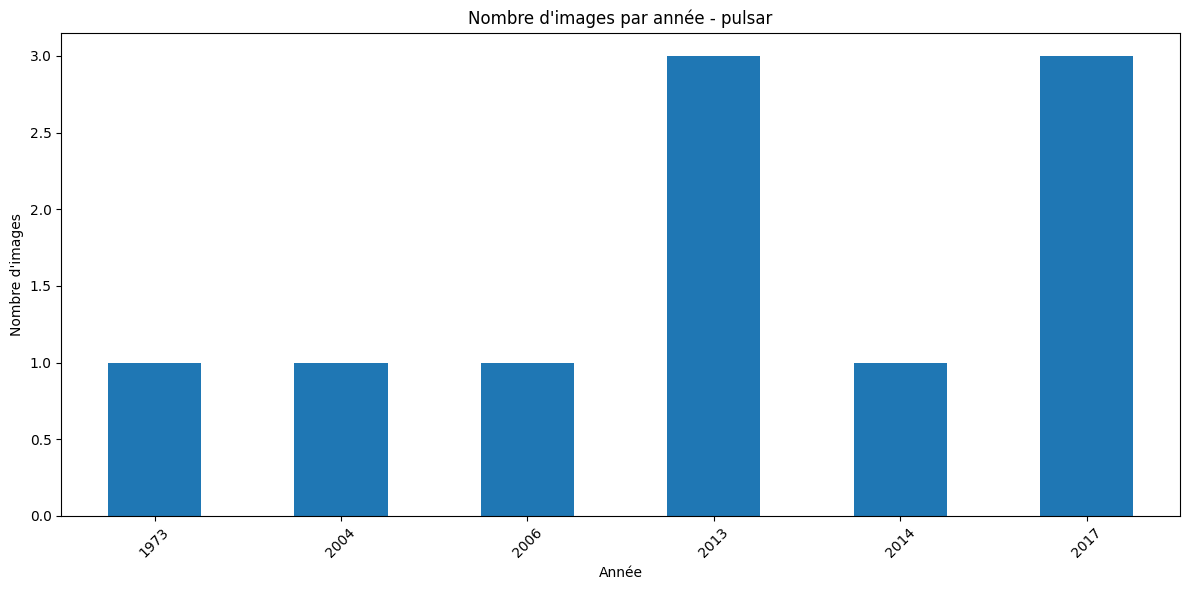

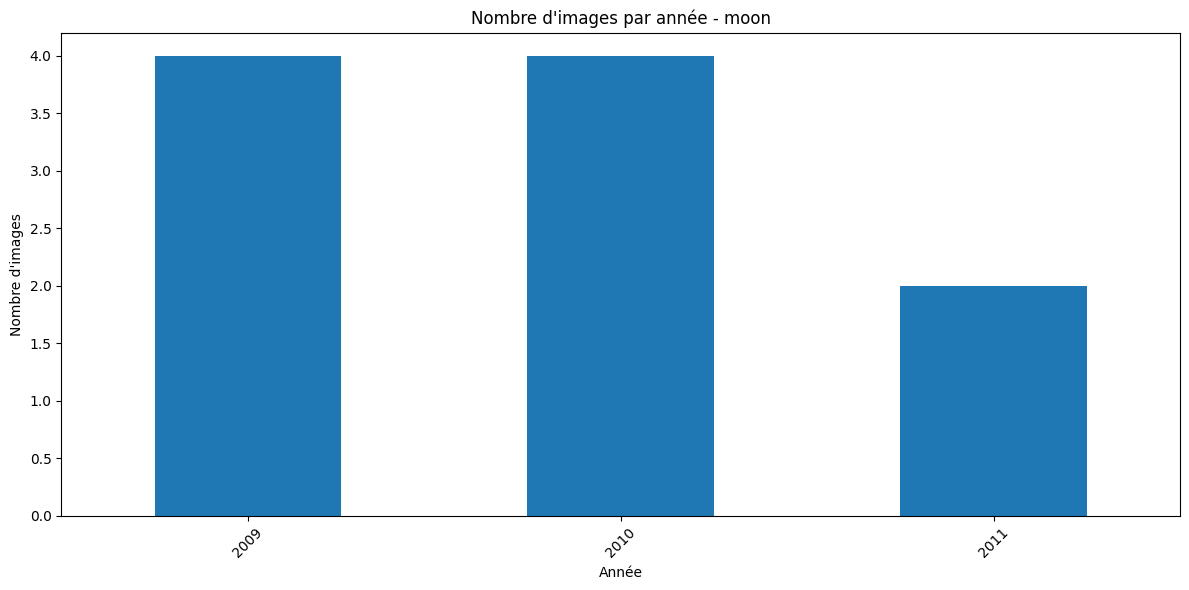

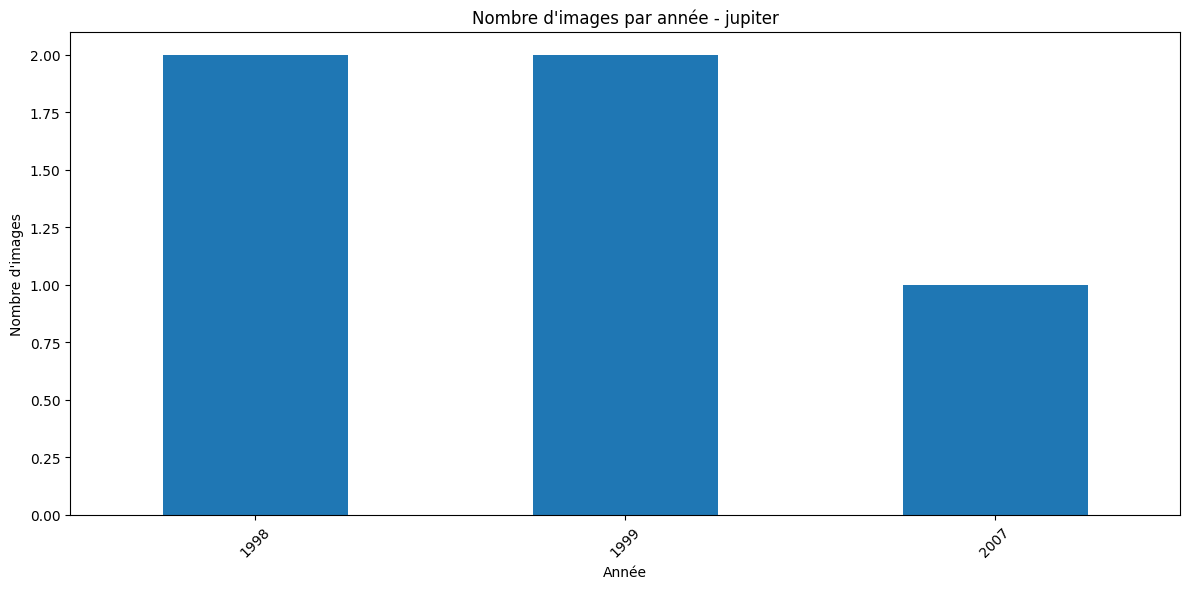

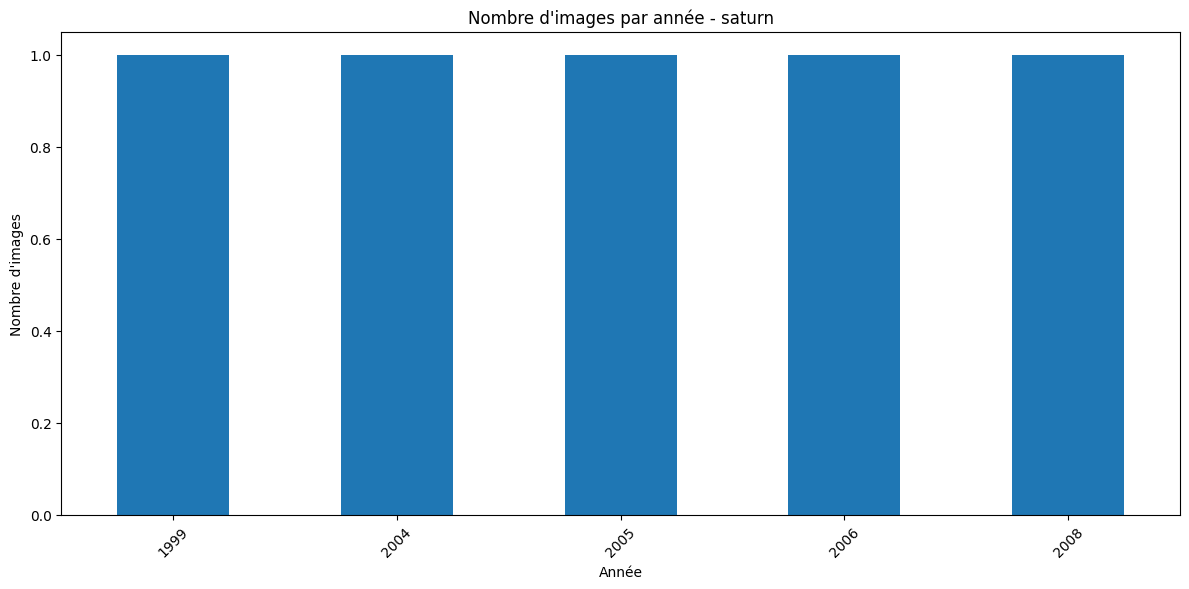

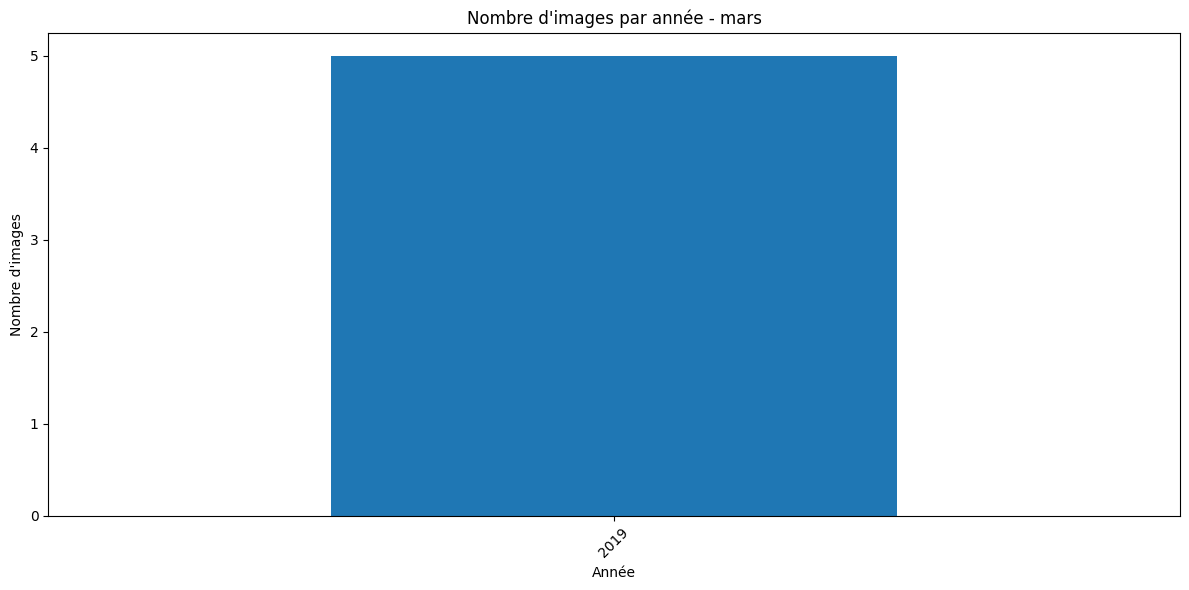

In [9]:
import json
import matplotlib.pyplot as plt
import pandas as pd

def analyze_nasa_images(json_path):
    # Charger les donn√©es
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Convertir en un format plat pour l'analyse
    all_images = []

    # V√©rifier si les donn√©es sont une liste ou un dictionnaire
    if isinstance(data, list):
        all_images = data
    else:
        for category, images in data.items():
            for img in images:
                img['category'] = category
                all_images.append(img)

    # Cr√©er un DataFrame
    df = pd.DataFrame(all_images)

    # Cr√©er une visualisation des images par ann√©e
    plt.figure(figsize=(12, 6))
    year_counts = df['year'].value_counts().sort_index()
    year_counts.plot(kind='bar')
    plt.title("Nombre d'images par ann√©e")
    plt.xlabel("Ann√©e")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Afficher le graphique dans Jupyter
    plt.show()

    # Afficher les statistiques
    print("\nStatistiques de la collection :")
    print(f"Nombre total d'images : {len(df)}")

    print("\nImages par ann√©e :")
    print(year_counts)

    if 'category' in df.columns:
        print("\nImages par cat√©gorie :")
        print(df['category'].value_counts())

        # Tracer les images par ann√©e pour chaque cat√©gorie
        for category in df['category'].unique():
            plt.figure(figsize=(12, 6))
            category_df = df[df['category'] == category]
            category_year_counts = category_df['year'].value_counts().sort_index()
            category_year_counts.plot(kind='bar')
            plt.title(f"Nombre d'images par ann√©e - {category}")
            plt.xlabel("Ann√©e")
            plt.ylabel("Nombre d'images")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    return df

# Utilisation du script
df = analyze_nasa_images('astronomy_dataset/metadata/nasa_images.json')




### 4.2. Le nombre d'images disponibles pour les diff√©rents types : taille de l'image, l'orientation des images, les mod√®les d'appareils photo, type de corps c√©leste. 

In [6]:
!pip install matplotlib

Generando gr√°ficos para la categor√≠a: asteroid


<Figure size 800x600 with 0 Axes>

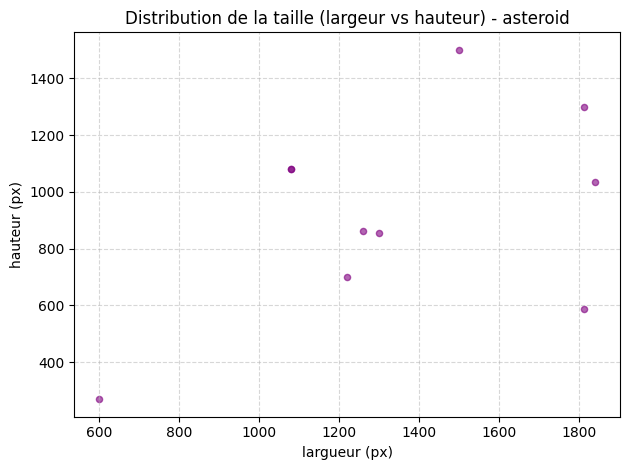

Generando gr√°ficos para la categor√≠a: black hole


<Figure size 800x600 with 0 Axes>

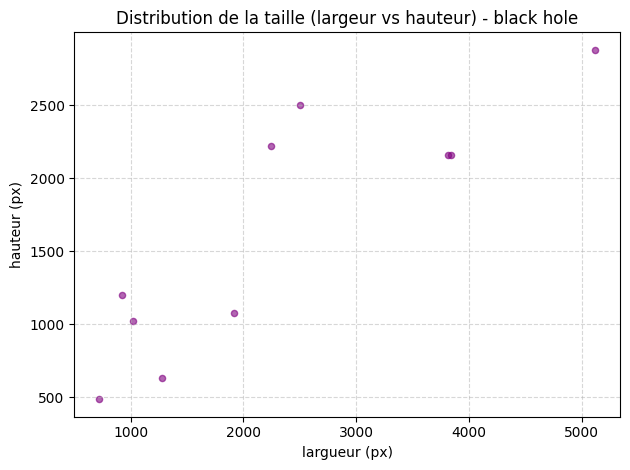

Generando gr√°ficos para la categor√≠a: black_hole


<Figure size 800x600 with 0 Axes>

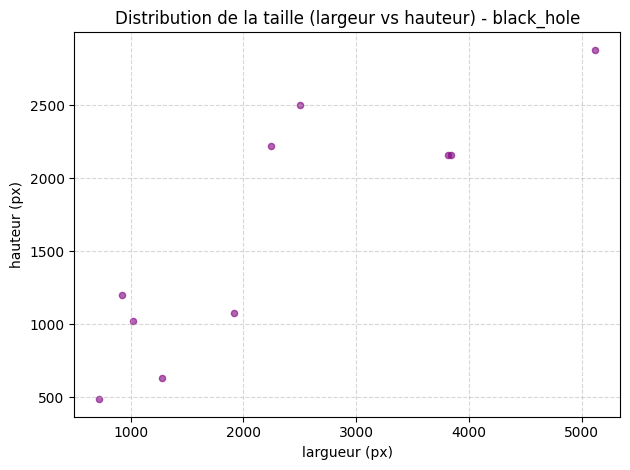

Generando gr√°ficos para la categor√≠a: galaxy


<Figure size 800x600 with 0 Axes>

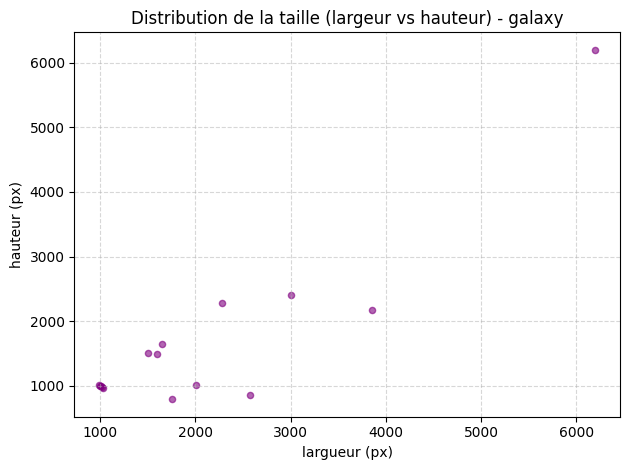

Generando gr√°ficos para la categor√≠a: jupiter


In [ ]:

import json
import matplotlib.pyplot as plt
import pandas as pd

def analyze_nasa_images(json_path):
    # Cargar los datos
    with open(json_path, 'r', encoding='utf-8') as f:
        all_images = json.load(f)

    # Transformar el tama√±o a un formato m√°s manejable (por ejemplo: "1920x1080")
    for image in all_images:
        if 'size' in image and 'width' in image['size'] and 'height' in image['size']:
            image['size'] = f"{image['size']['width']}x{image['size']['height']}"

        # Extraer el equipo (Make o Model en EXIF), si est√° disponible
        exif = image.get('exif', {})
        image['equipment'] = exif.get('Make', exif.get('Model', 'Desconocido'))

    # Crear DataFrame
    df = pd.DataFrame(all_images)

    # Iterar sobre cada categor√≠a para generar gr√°ficos
    for category in df['category'].unique():
        category_df = df[df['category'] == category]

        print(f"Generando gr√°ficos para la categor√≠a: {category}")

        # Gr√°fico de dispersi√≥n del tama√±o (ancho vs alto)
        plt.figure(figsize=(8, 6))
        category_df['size'].str.extract(r'(\d+)x(\d+)').astype(int).plot.scatter(x=0, y=1, alpha=0.6, color='purple')
        plt.title(f"Distribution de la taille (largeur vs hauteur) - {category}")
        plt.xlabel("largueur (px)")
        plt.ylabel("hauteur (px)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


# Uso del script
analyze_nasa_images('astronomy_dataset/metadata/extracted_metadata.json')

Generando gr√°ficos para la categor√≠a: asteroid


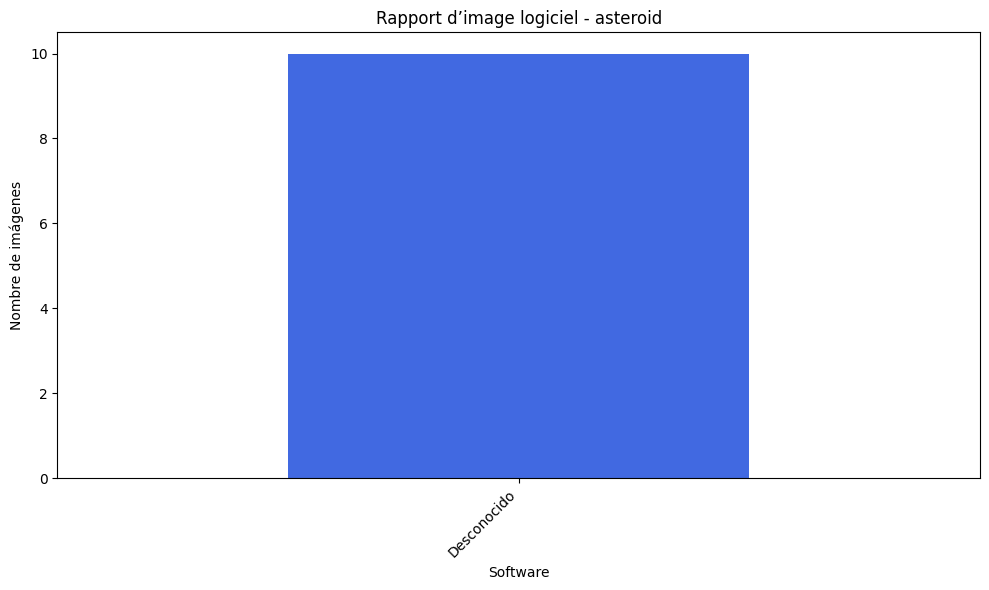

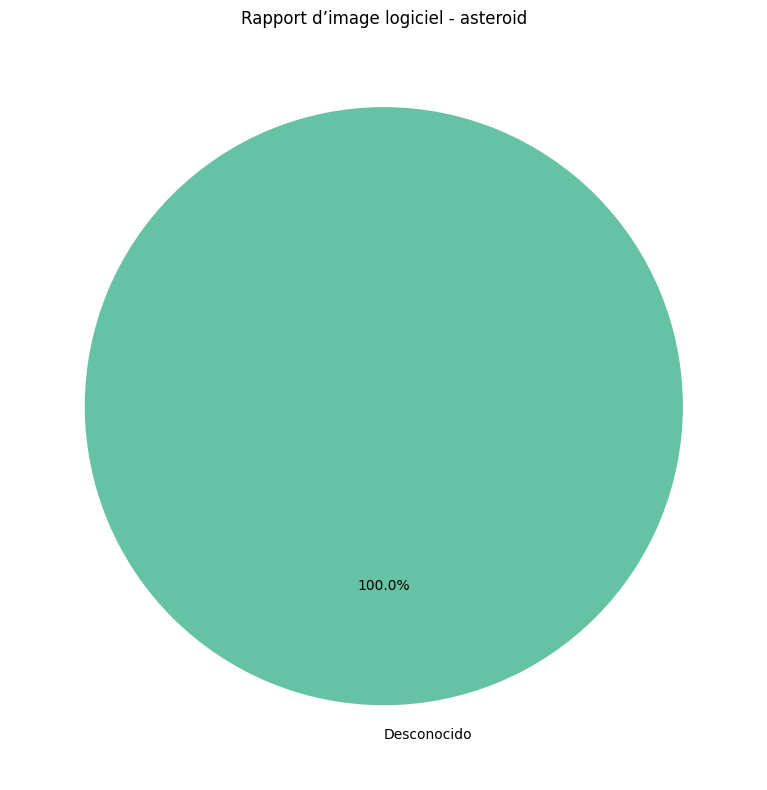

Generando gr√°ficos para la categor√≠a: black hole


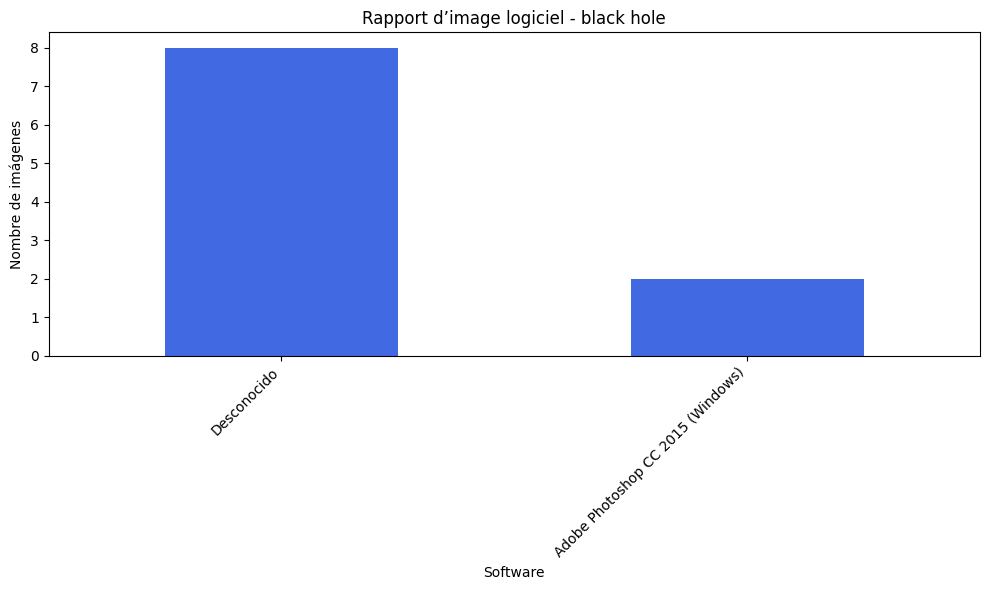

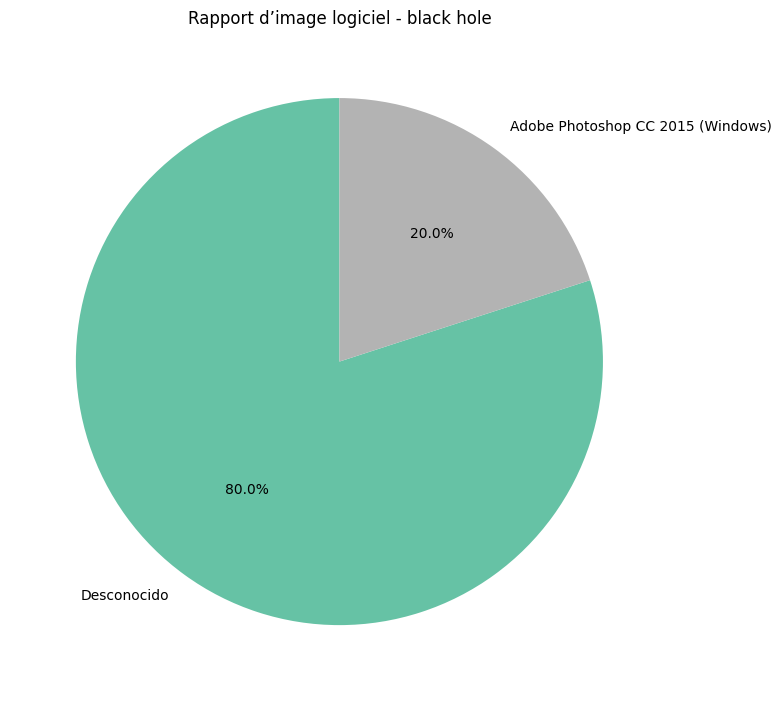

Generando gr√°ficos para la categor√≠a: black_hole


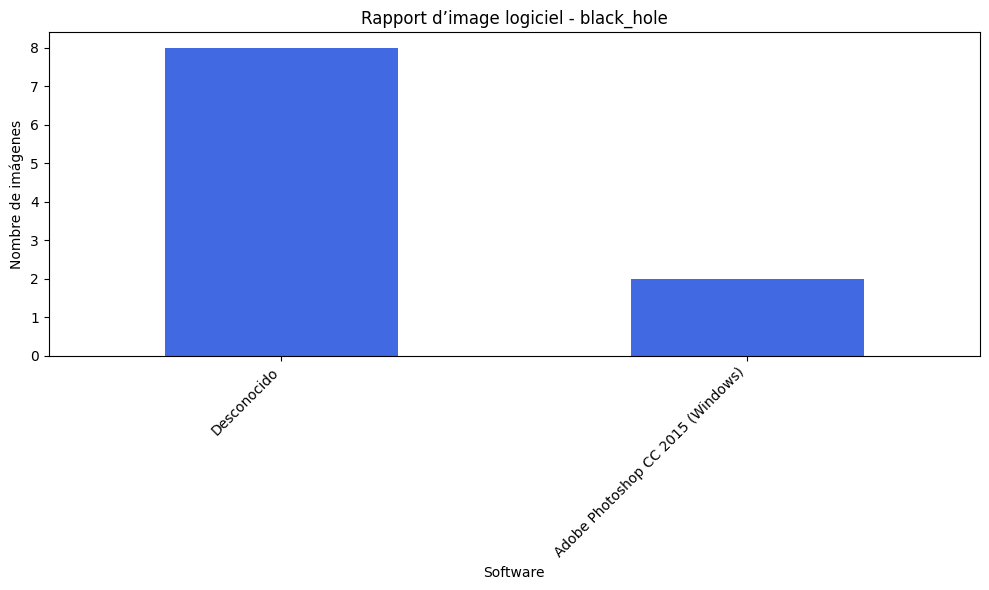

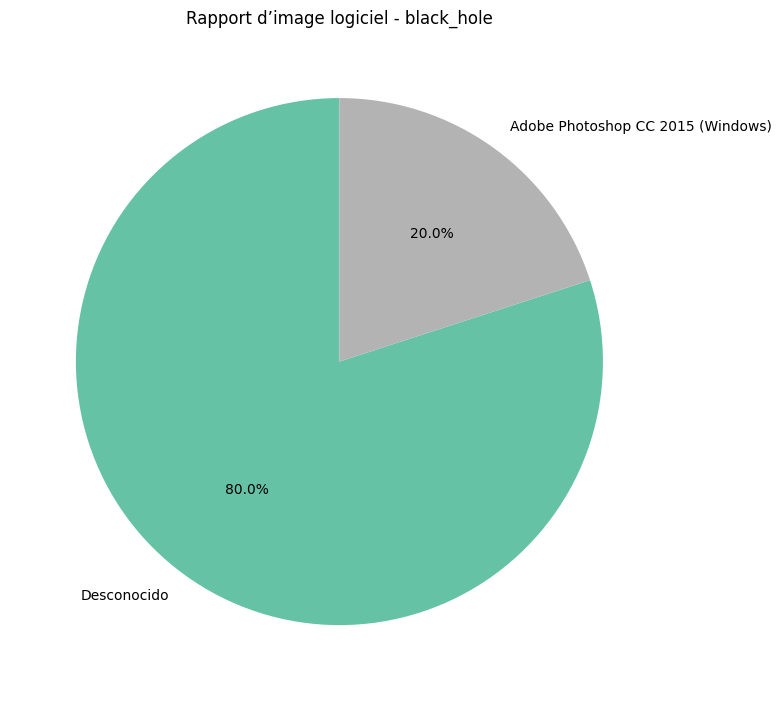

Generando gr√°ficos para la categor√≠a: galaxy


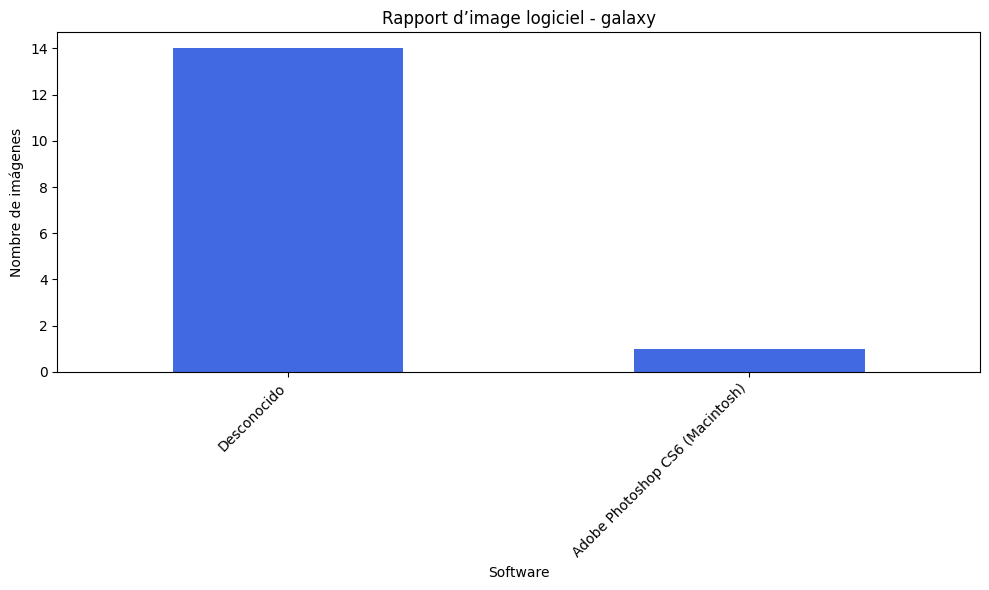

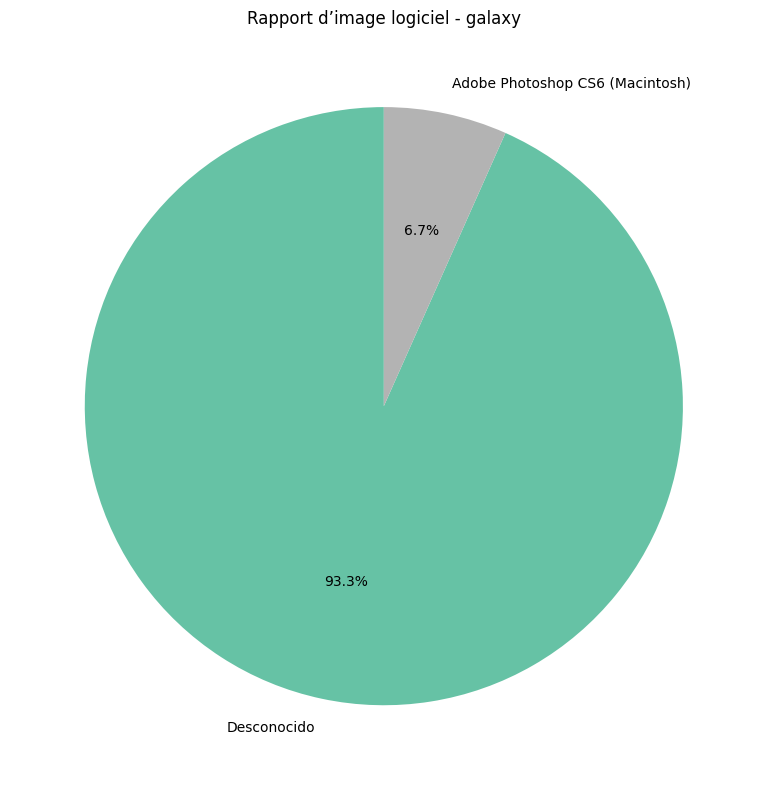

Generando gr√°ficos para la categor√≠a: jupiter


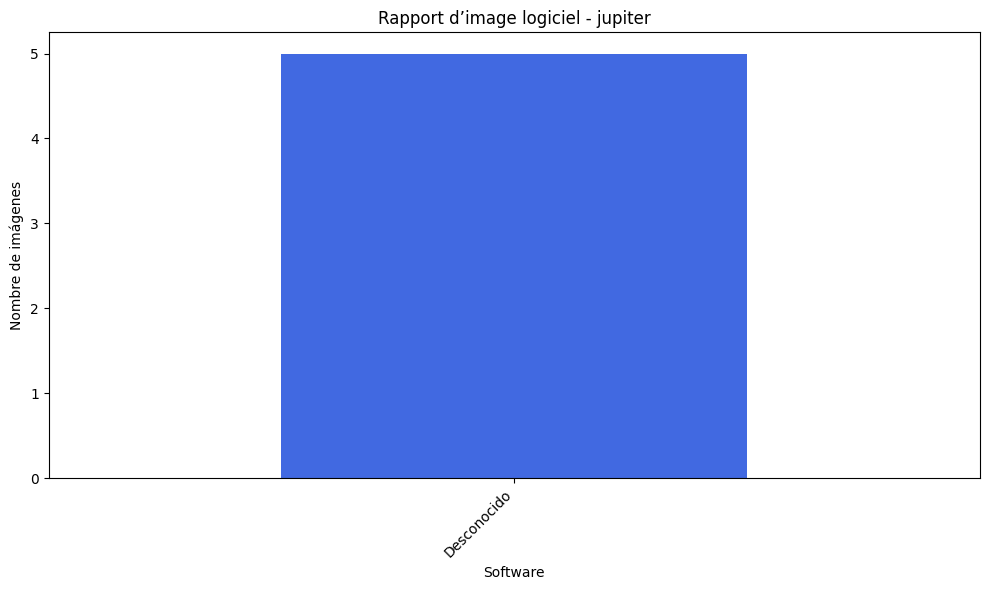

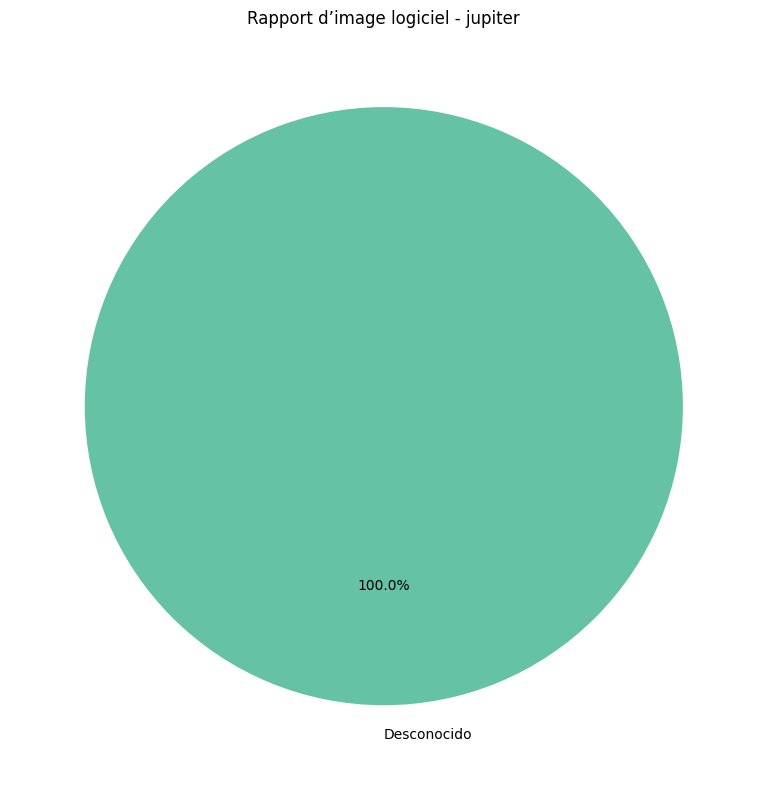

Generando gr√°ficos para la categor√≠a: moon


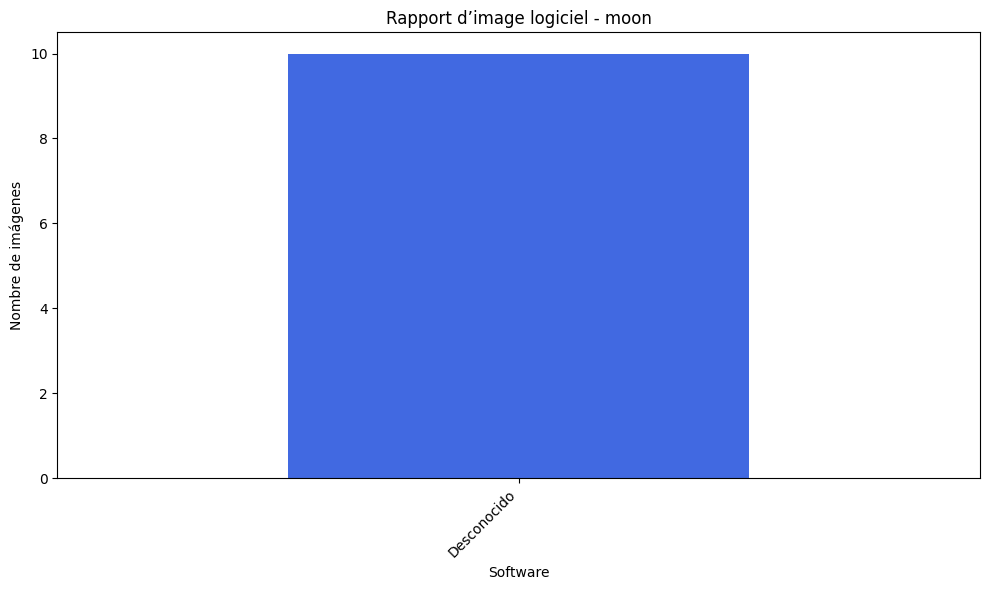

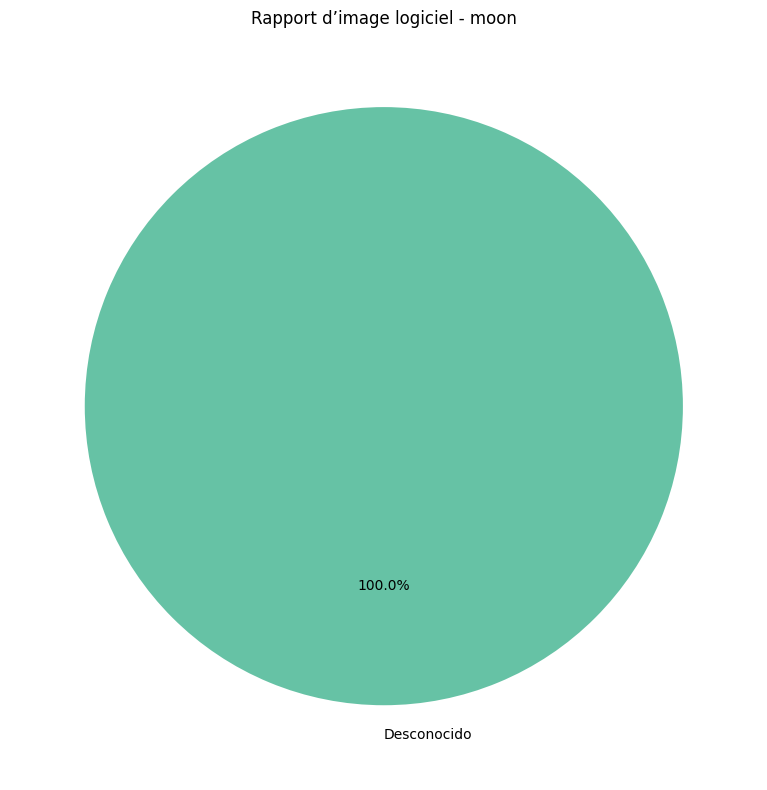

Generando gr√°ficos para la categor√≠a: nebula


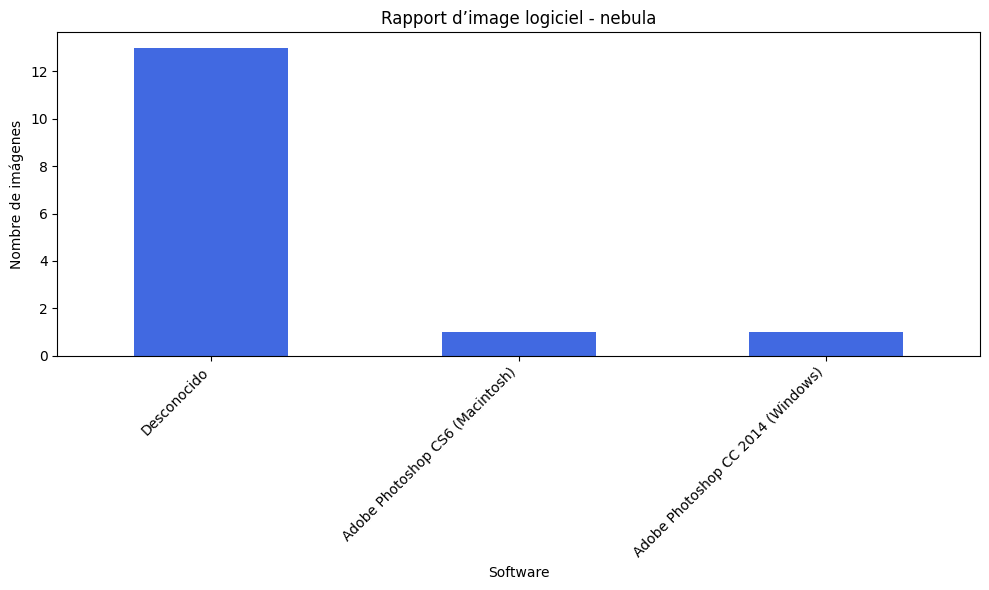

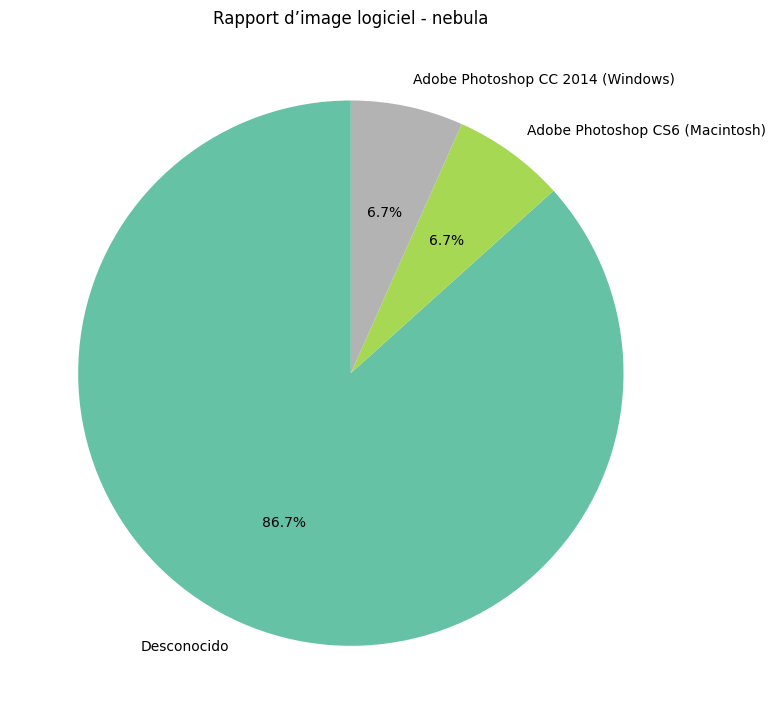

Generando gr√°ficos para la categor√≠a: planet


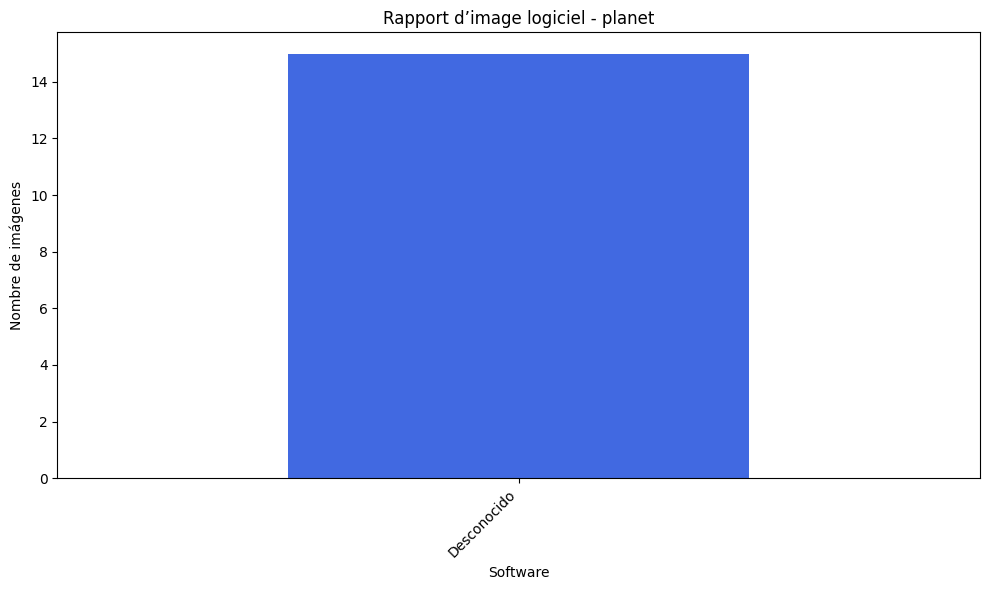

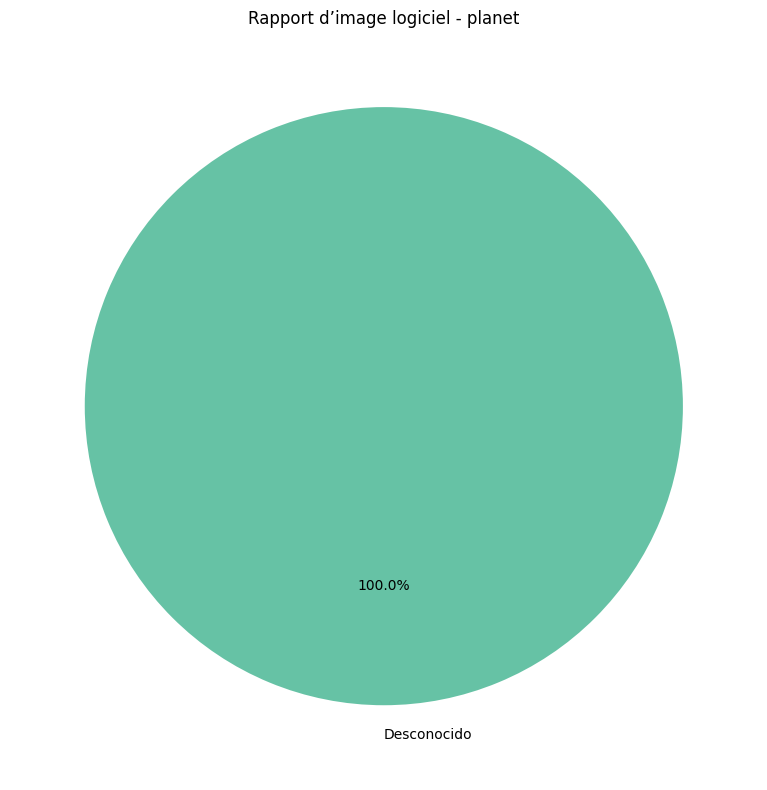

Generando gr√°ficos para la categor√≠a: pulsar


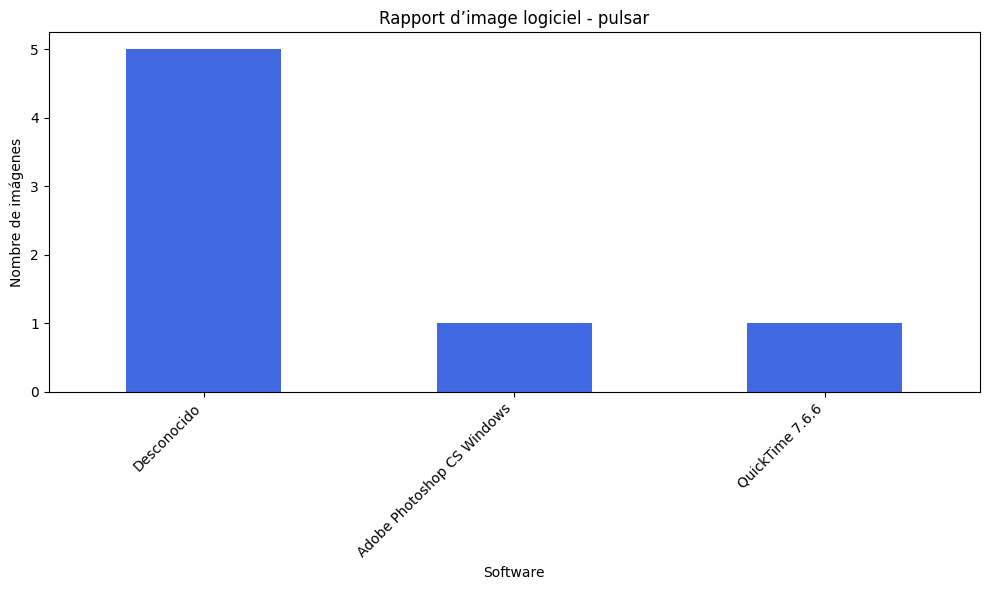

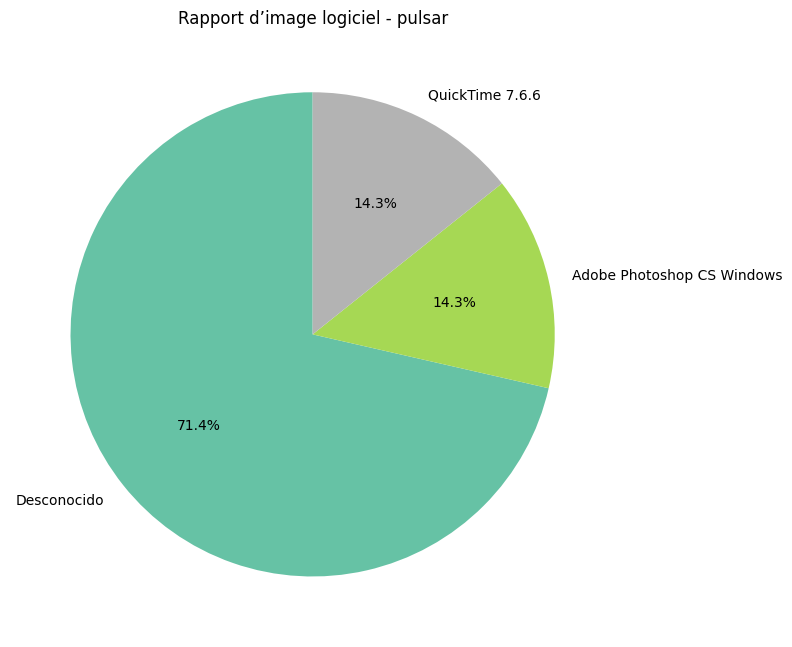

Generando gr√°ficos para la categor√≠a: saturn


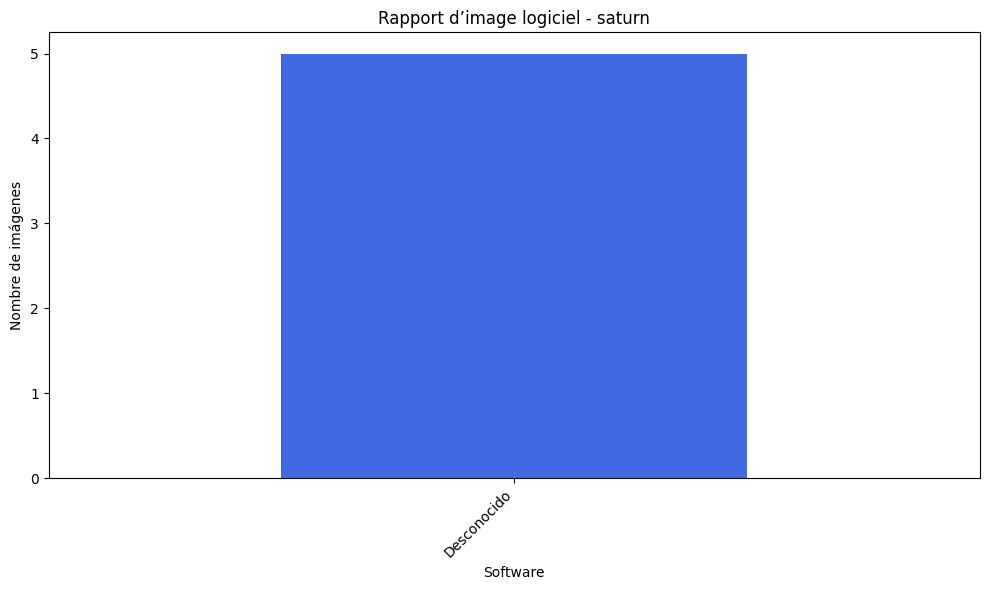

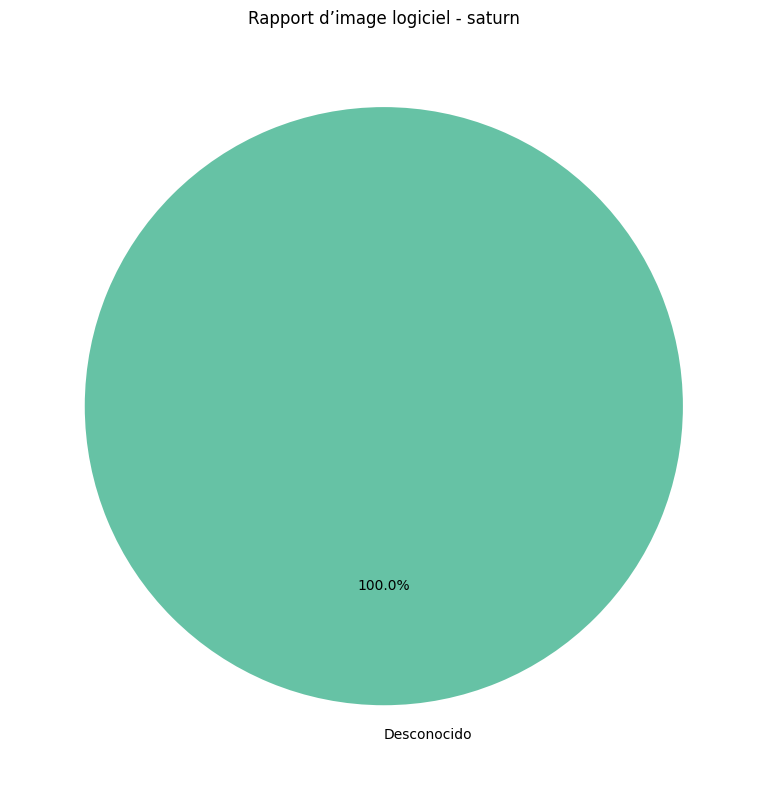

Generando gr√°ficos para la categor√≠a: star


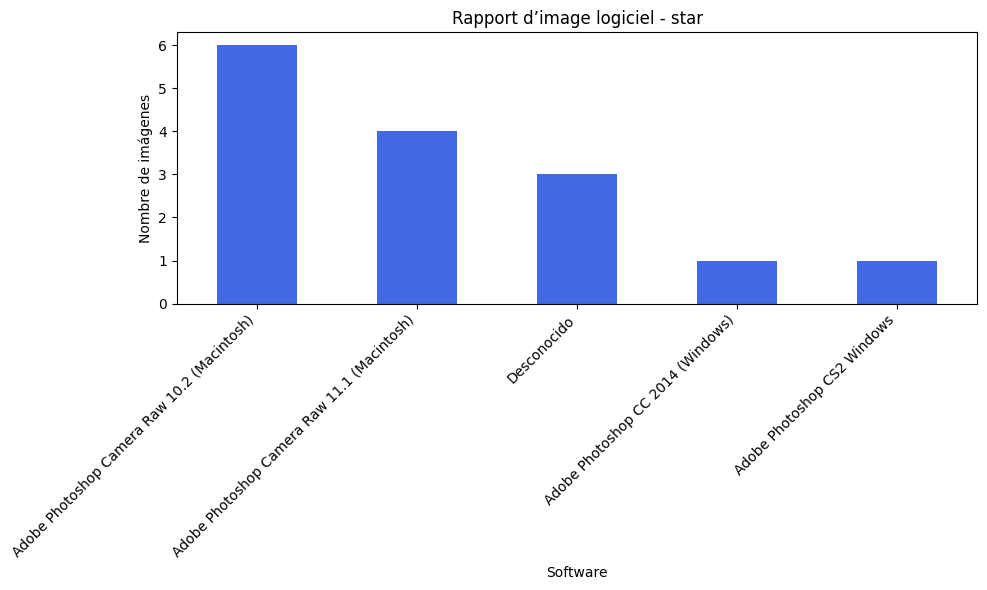

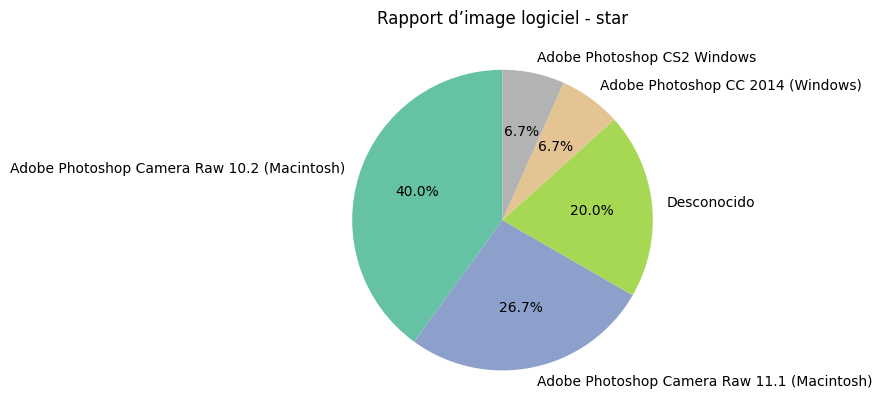

Generando gr√°ficos para la categor√≠a: supernova


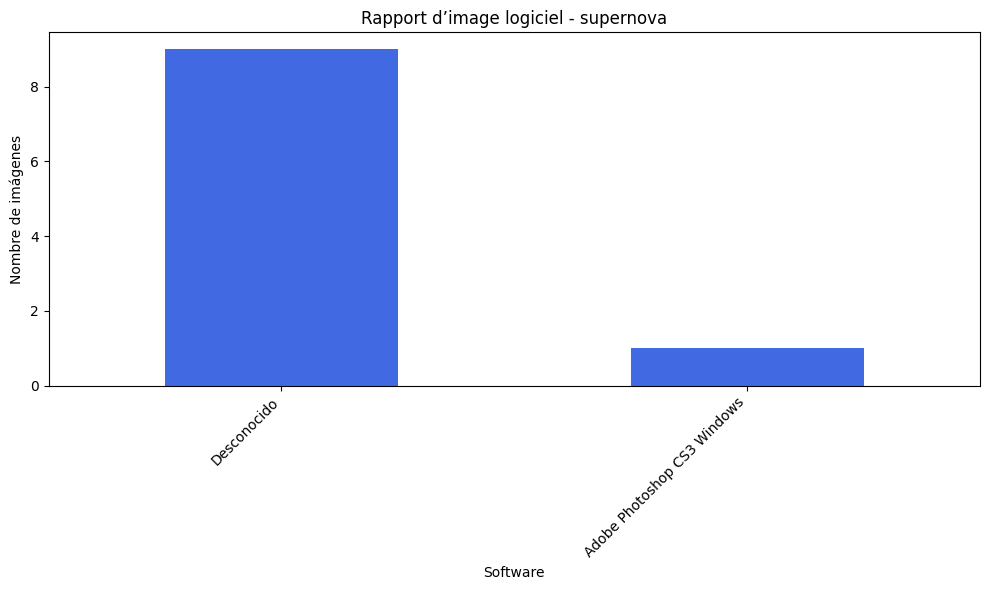

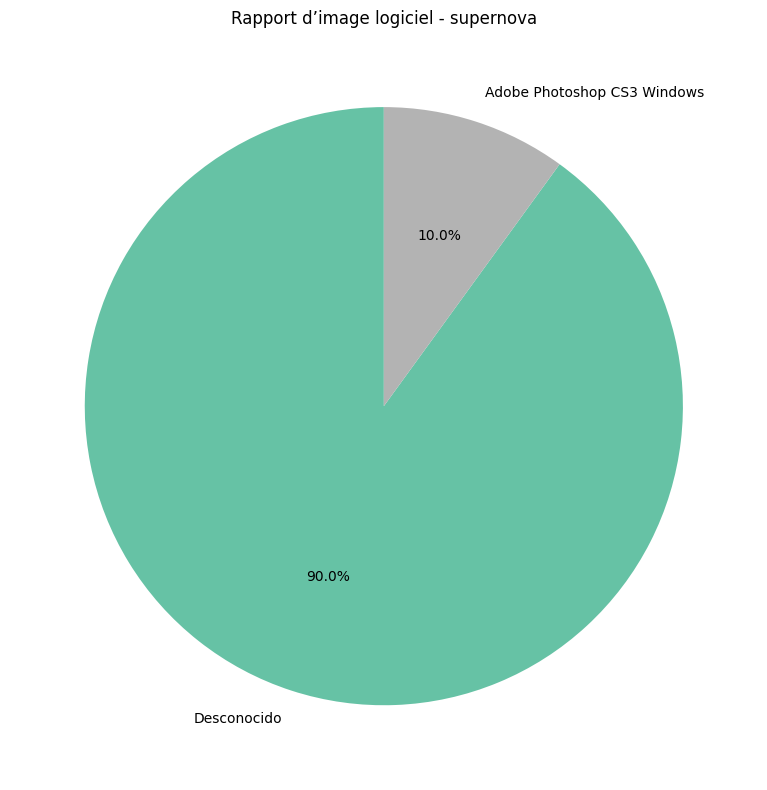

In [59]:
import json
import matplotlib.pyplot as plt
import pandas as pd

def plot_by_software_per_category(json_path):
    # Cargar los datos
    with open(json_path, 'r', encoding='utf-8') as f:
        all_images = json.load(f)

    # Crear un DataFrame de pandas
    df = pd.DataFrame(all_images)

    # Extraer el campo "Software" dentro de la columna "exif"
    df['software'] = df['exif'].apply(lambda x: x.get('Software', 'Desconocido'))

    # Iterar por cada categor√≠a
    for category in df['category'].unique():
        category_df = df[df['category'] == category]

        print(f"Generando gr√°ficos para la categor√≠a: {category}")

        # Contar la frecuencia de cada software en la categor√≠a actual
        software_counts = category_df['software'].value_counts()

        if software_counts.empty:
            print(f"No hay datos de software para la categor√≠a {category}")
            continue

        # Gr√°fico de barras
        plt.figure(figsize=(10, 6))
        software_counts.plot(kind='bar', color='royalblue')
        plt.title(f"Rapport d‚Äôimage logiciel - {category}")
        plt.xlabel("Software")
        plt.ylabel("Nombre de im√°genes")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Gr√°fico de pastel
        plt.figure(figsize=(8, 8))
        software_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set2')
        plt.title(f"Rapport d‚Äôimage logiciel - {category}")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()

# Ruta del JSON
plot_by_software_per_category('astronomy_dataset/metadata/extracted_metadata.json')

### 4.3. Caract√©ristiques des couleurs

In [ ]:
!pip install scikit-learn pillow numpy matplotlib
!pip install opencv-python


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


G√©n√©ration des palettes de couleurs par cat√©gorie...


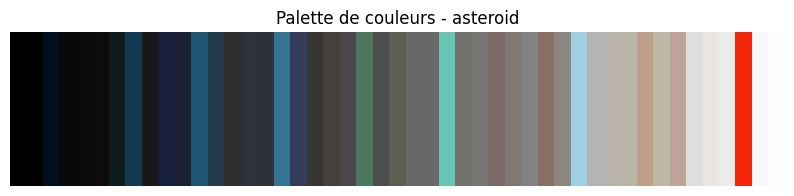

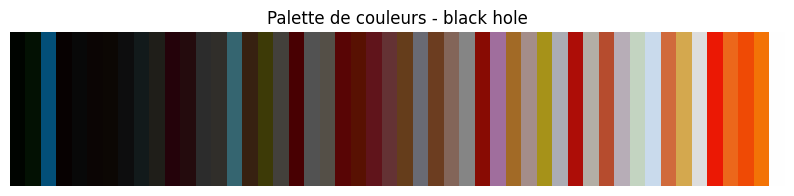

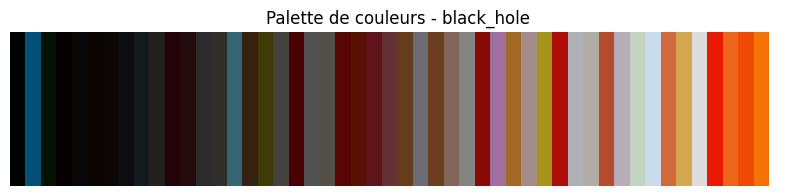

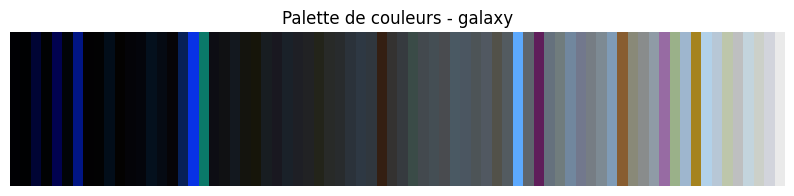

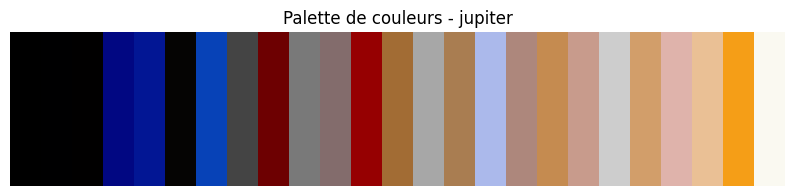

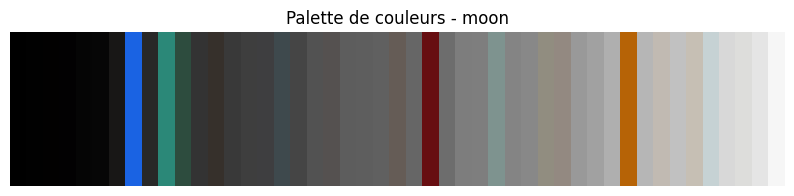

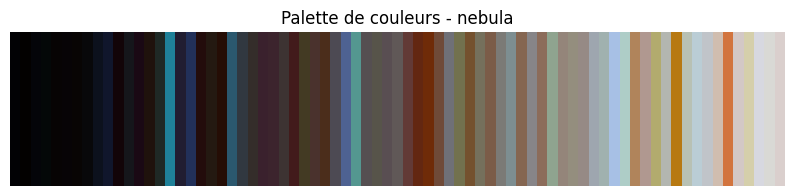

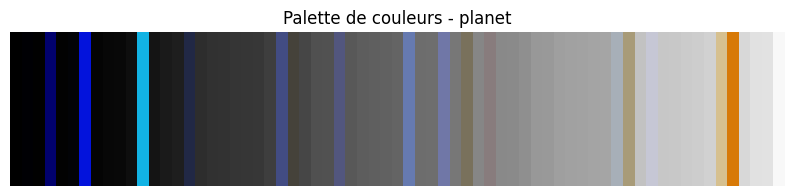

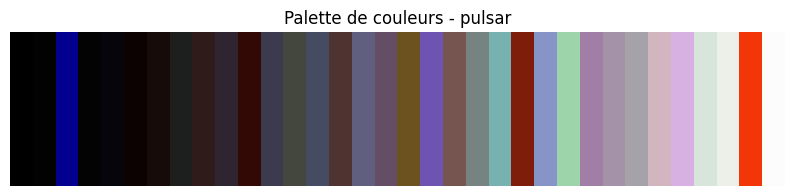

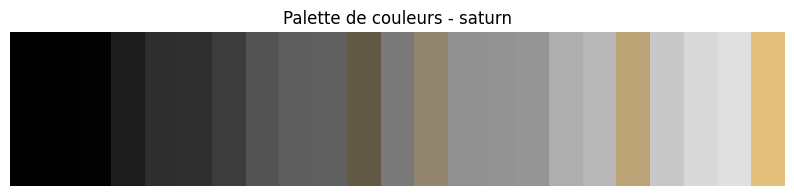

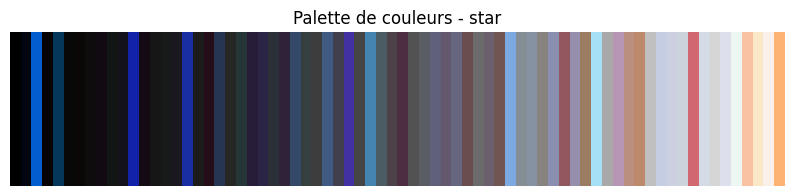

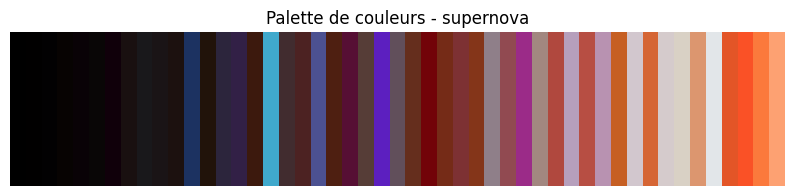

G√©n√©ration des histogrammes de couleurs RGB par cat√©gorie...


MemoryError: 

In [61]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

def extract_colors(image_path, n_clusters=5):
    """Extrait les couleurs dominantes d'une image en utilisant K-Means."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = image.reshape((-1, 3))

    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(pixels)

    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)

    return colors, counts

def plot_category_colors(image_data, n_clusters=5):
    """Affiche la palette de couleurs dominante pour chaque cat√©gorie d'images."""
    category_colors = {}

    for image_info in image_data:
        category = image_info['category']
        image_path = image_info['file_path']

        if category not in category_colors:
            category_colors[category] = []

        colors, _ = extract_colors(image_path, n_clusters)
        category_colors[category].extend(colors)

    # Affichage des couleurs par cat√©gorie
    for category, colors in category_colors.items():
        unique_colors, counts = np.unique(np.array(colors), axis=0, return_counts=True)

        plt.figure(figsize=(10, 2))
        plt.title(f"Palette de couleurs - {category}")
        plt.imshow([unique_colors], aspect='auto')
        plt.axis('off')
        plt.show()

def plot_rgb_histograms(image_data):
    """G√©n√®re des histogrammes des couleurs RGB pour chaque cat√©gorie."""
    for category in set(img['category'] for img in image_data):
        category_images = [img['file_path'] for img in image_data if img['category'] == category]

        red_vals, green_vals, blue_vals = [], [], []

        for img_path in category_images:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            red_vals.extend(image[:, :, 0].flatten())
            green_vals.extend(image[:, :, 1].flatten())
            blue_vals.extend(image[:, :, 2].flatten())

        plt.figure(figsize=(10, 4))
        plt.title(f"Distribution des couleurs RGB - {category}")
        plt.hist(red_vals, bins=50, color='red', alpha=0.6, label='Rouge')
        plt.hist(green_vals, bins=50, color='green', alpha=0.6, label='Vert')
        plt.hist(blue_vals, bins=50, color='blue', alpha=0.6, label='Bleu')

        plt.xlabel("Intensit√© de couleur")
        plt.ylabel("Fr√©quence")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    metadata_path = 'astronomy_dataset/metadata/extracted_metadata.json'

    # Charger les m√©tadonn√©es des images
    with open(metadata_path, 'r', encoding='utf-8') as f:
        image_data = json.load(f)

    print("G√©n√©ration des palettes de couleurs par cat√©gorie...")
    plot_category_colors(image_data)

    print("G√©n√©ration des histogrammes de couleurs RGB par cat√©gorie...")
    plot_rgb_histograms(image_data)


## 5. Syst√®me de recommandation

Dans cette t√¢che, l'objectif est de construire le syst√®me de recommandation des images √† un utilisateur. 

### Questions:

1. Quelle approche avez-vous d√©cid√© de prendre ? Filtrage collaboratif, bas√© sur le contenu ou une approche hybride ? 

    - L‚Äôapproche utilis√©e est bas√©e sur le contenu. Cette approche se concentre sur les caract√©ristiques de l‚Äôimage (telles que les couleurs, la luminosit√©, la taille, etc.) et les pr√©f√©rences explicites de l‚Äôutilisateur (raisons de ses choix) pour faire des recommandations. Le syst√®me tente de trouver des similitudes entre les images pr√©f√©r√©es de l‚Äôutilisateur et les images disponibles dans la galerie, √† l‚Äôaide de fonctionnalit√©s visuelles et en les regroupant √† l‚Äôaide du clustering (KMeans) pour g√©n√©rer des recommandations.

2. Quel(s) algorithme(s) avez-vous choisi (classification, clustering, ...) ? 

    - L‚Äôalgorithme de clustering a √©t√© principalement choisi, en particulier l‚Äôalgorithme KMeans.
    En outre, des techniques de pr√©traitement des donn√©es telles que la normalisation (avec StandardScaler) sont √©galement utilis√©es pour s‚Äôassurer que les entit√©s sont √† une √©chelle comparable avant le clustering.
    Bien qu‚Äôil ne s‚Äôagisse pas d‚Äôun algorithme de classification (o√π des √©tiquettes ou des cat√©gories pr√©d√©finies sont attribu√©es), l‚Äôutilisation de KMeans dans ce cas permet d‚Äôorganiser les images en groupes similaires en fonction de leurs caract√©ristiques, ce qui est au c≈ìur de l‚Äôapproche de clustering.

3. Pour chaque utilisateur, √™tes-vous maintenant en mesure de construire une profil ? 

    - Oui, le syst√®me est capable de cr√©er un profil pour chaque utilisateur, en utilisant √† la fois les photos que l‚Äôutilisateur a marqu√©es comme favorites et les raisons qu‚Äôil donne pour son choix. Ce profil est ensuite utilis√© pour faire des recommandations d‚Äôimages en fonction des caract√©ristiques communes que l‚Äôutilisateur pr√©f√®re.

4. Quel type d'information avez-vous utilis√© pour √©tablir un profil d'utilisateur profil ? Qu'est-ce qui manque ? Quelles sont les limites de votre proposition ?

    - Pour cr√©er un profil d‚Äôutilisateur, le syst√®me utilise principalement les pr√©f√©rences explicites de l‚Äôutilisateur, c‚Äôest-√†-dire les images qu‚Äôil a marqu√©es comme favorites et les raisons de ces choix. De plus, il analyse les caract√©ristiques visuelles des images, telles que les couleurs dominantes, la luminosit√© moyenne, la taille et le rapport hauteur/largeur. La cat√©gorie des images est √©galement prise en compte, mais elle n‚Äôaffecte pas directement le profil. Cependant, le syst√®me pr√©sente quelques faiblesses. Il ne contient pas de pr√©f√©rences implicites, telles que le temps que l‚Äôutilisateur passe √† regarder une image ou le fait qu‚Äôil clique dessus sans la marquer comme favorite. Cela permettrait d‚Äôobtenir une vue plus compl√®te de l‚Äôutilisateur. Il serait √©galement utile d‚Äôavoir plus d‚Äôinformations sur les interactions pass√©es, telles que les images que l‚Äôutilisateur a vues mais n‚Äôa pas signal√©es, ou la fa√ßon dont il a r√©agi aux recommandations pr√©c√©dentes. 
    - Un autre aspect qui manque est le contexte des choix de l‚Äôutilisateur. Par exemple, le syst√®me ne tient pas compte du fait que la pr√©f√©rence d‚Äôune image d√©pend de facteurs tels que l‚Äôheure de la journ√©e ou l‚Äôhumeur de l‚Äôutilisateur, ce qui pourrait personnaliser les recommandations plus pr√©cis√©ment. Le syst√®me a des limites, telles que le recours √† des pr√©f√©rences explicites, ce qui peut √™tre un probl√®me pour les utilisateurs qui ne fournissent pas beaucoup de commentaires directs. De plus, l‚Äôutilisation de KMeans pour regrouper des images n‚Äôest peut-√™tre pas la plus efficace √† mesure que le catalogue s‚Äôagrandit, et les fonctionnalit√©s visuelles utilis√©es sont assez simples. L‚Äôam√©lioration de ces fonctionnalit√©s et l‚Äôexploration d‚Äôapproches plus avanc√©es pourraient rendre les recommandations plus pr√©cises et plus √©volutives.

In [58]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
import shutil
import re

# Dossiers de base
IMAGE_FOLDER = "astronomy_dataset/images/"
USER_FOLDER = "usuarios/"
RECOMMENDATION_FOLDER = "recomendacion/"

# Cr√©er un dossier pour les recommandations si il n'existe pas
os.makedirs(RECOMMENDATION_FOLDER, exist_ok=True)

def extract_image_features(image_path):
    """Extrait les caract√©ristiques visuelles de l'image : couleurs dominantes, taille, orientation."""
    try:
        img = Image.open(image_path).convert("RGB")
        width, height = img.size
        
        # R√©duire la taille pour une analyse rapide
        img_resized = img.resize((100, 100))
        
        # Extraire les couleurs dominantes
        pixels = np.array(img_resized).reshape(-1, 3)
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(pixels)
        dominant_colors = kmeans.cluster_centers_.flatten()
        
        # Calculer la luminosit√© moyenne
        brightness = np.mean(pixels, axis=0).mean()
        
        # Calculer le rapport d'aspect
        aspect_ratio = width / height
        
        # Taille de l'image en m√©gapixels
        size_mp = (width * height) / 1000000
        
        return {
            'dominant_colors': dominant_colors,
            'brightness': brightness,
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'size_mp': size_mp,
            'path': image_path
        }
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_path}: {e}")
        return None

def extract_metadata_from_path(image_path):
    """Extrait les m√©tadonn√©es du chemin de l'image (cat√©gorie)."""
    # Extraire la cat√©gorie du chemin
    match = re.search(r'images/([^/\\]+)', image_path)
    category = match.group(1) if match else "inconnu"
    
    return {
        'category': category,
        'path': image_path
    }

def parse_user_preferences(user):
    """Analyse les pr√©f√©rences de l'utilisateur √† partir de son fichier JSON."""
    user_file = os.path.join(USER_FOLDER, f"{user}.json")
    if not os.path.exists(user_file):
        print(f"Le fichier de l'utilisateur {user} n'existe pas.")
        return []
    
    try:
        with open(user_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        liked_images = data.get("likes", [])
        
        # Structure des pr√©f√©rences
        preferences = []
        for item in liked_images:
            path = item.get("path")
            reason = item.get("reason")
            
            if path and reason:
                # Normaliser les raisons
                normalized_reason = reason.lower().strip()
                preferences.append({
                    'path': path,
                    'reason': normalized_reason
                })
        
        return preferences
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier utilisateur {user}: {e}")
        return []

def process_all_images():
    """Traite toutes les images et extrait les caract√©ristiques et m√©tadonn√©es."""
    all_images = []
    
    # Parcourir toutes les cat√©gories
    for category in os.listdir(IMAGE_FOLDER):
        category_path = os.path.join(IMAGE_FOLDER, category)
        if os.path.isdir(category_path):
            for image_file in os.listdir(category_path):
                if image_file.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_path = os.path.join(category_path, image_file)
                    # Extraire les caract√©ristiques visuelles
                    features = extract_image_features(image_path)
                    if features:
                        # Extraire les m√©tadonn√©es
                        metadata = extract_metadata_from_path(image_path)
                        # Combiner les deux
                        image_data = {**features, **metadata}
                        all_images.append(image_data)
    
    return all_images

def create_feature_matrix(images_data):
    """Cr√©e une matrice de caract√©ristiques pour le clustering."""
    # Extraire les caract√©ristiques visuelles
    visual_features = []
    paths = []
    categories = []
    
    for img in images_data:
        # Caract√©ristiques visuelles
        features = [
            *img['dominant_colors'],  # D√©baller les couleurs dominantes
            img['brightness'],
            img['aspect_ratio'],
            img['size_mp']
        ]
        visual_features.append(features)
        paths.append(img['path'])
        categories.append(img['category'])
    
    # Convertir en tableau numpy
    X = np.array(visual_features)
    
    # Normaliser les caract√©ristiques
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, paths, categories

def cluster_user_preferences(user_preferences, all_images_data):
    """Analyse les mod√®les dans les pr√©f√©rences de l'utilisateur en utilisant KMeans."""
    if not user_preferences:
        return None, {}
    
    # Compter les raisons des pr√©f√©rences
    reason_counter = Counter([pref['reason'] for pref in user_preferences])
    
    # V√©rifier s'il y a suffisamment d'exemples pour l'entra√Ænement
    min_samples = 2  # Minimum d'√©chantillons par groupe pour faire du clustering
    
    preference_patterns = {}
    for reason, count in reason_counter.items():
        if count >= min_samples:
            # Filtrer les images par raison
            reason_images = [pref['path'] for pref in user_preferences if pref['reason'] == reason]
            
            # Trouver les images correspondantes dans les donn√©es
            reason_features = []
            for path in reason_images:
                # Chercher l'image dans all_images_data
                for img_data in all_images_data:
                    if img_data['path'] == path:
                        # Extraire les caract√©ristiques pour le clustering
                        features = [
                            *img_data['dominant_colors'],
                            img_data['brightness'],
                            img_data['aspect_ratio'],
                            img_data['size_mp']
                        ]
                        reason_features.append(features)
                        break
            
            if len(reason_features) >= min_samples:
                # Normaliser les caract√©ristiques
                scaler = StandardScaler()
                features_scaled = scaler.fit_transform(np.array(reason_features))
                
                # Appliquer KMeans
                n_clusters = min(len(reason_features) // 2, 3)  # Maximum de 3 clusters
                if n_clusters < 1:
                    n_clusters = 1
                
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                kmeans.fit(features_scaled)
                
                # Sauvegarder le mod√®le et le scaler
                preference_patterns[reason] = {
                    'model': kmeans,
                    'scaler': scaler,
                    'count': count
                }
    
    return preference_patterns

def recommend_images(user, all_images_data, max_recommendations=10):
    """G√©n√®re des recommandations bas√©es sur les mod√®les de pr√©f√©rence de l'utilisateur."""
    # Obtenir les pr√©f√©rences de l'utilisateur
    user_preferences = parse_user_preferences(user)
    
    if not user_preferences:
        print(f"Aucune pr√©f√©rence trouv√©e pour l'utilisateur {user}.")
        return []
    
    # Obtenir les chemins des images que l'utilisateur aime
    liked_paths = [pref['path'] for pref in user_preferences]
    
    # Obtenir les mod√®les de pr√©f√©rence
    preference_patterns = cluster_user_preferences(user_preferences, all_images_data)
    
    # Si aucun mod√®le n'est trouv√©, utiliser une m√©thode de base
    if not preference_patterns:
        print("Aucun mod√®le de pr√©f√©rence clair trouv√©, utilisation de la m√©thode de base...")
        return basic_recommendation(user_preferences, all_images_data, liked_paths, max_recommendations)
    
    # Ensemble pour les recommandations
    recommendations = []
    reason_recommendations = {}
    
    # Cr√©er la matrice de caract√©ristiques pour toutes les images
    X_all, all_paths, all_categories = create_feature_matrix(all_images_data)
    
    # Pour chaque raison de pr√©f√©rence
    for reason, pattern_data in preference_patterns.items():
        model = pattern_data['model']
        scaler = pattern_data['scaler']
        count = pattern_data['count']
        
        # Normaliser les caract√©ristiques
        X_scaled = scaler.transform(X_all)
        
        # Pr√©dire les clusters pour toutes les images
        clusters = model.predict(X_scaled)
        
        # Trouver les images de pr√©f√©rence pour cette raison
        reason_liked_paths = [pref['path'] for pref in user_preferences if pref['reason'] == reason]
        
        # Trouver les indices des images que l'utilisateur aime
        liked_indices = [i for i, path in enumerate(all_paths) if path in liked_paths]
        
        if liked_indices:
            liked_clusters = [clusters[i] for i in liked_indices]
            target_cluster = Counter(liked_clusters).most_common(1)[0][0]
            
            # Recommander des images du m√™me cluster que l'utilisateur n'a pas vues
            reason_recs = [
                all_paths[i] for i, cluster in enumerate(clusters) 
                if cluster == target_cluster and all_paths[i] not in liked_paths
            ]
            
            # Sauvegarder les recommandations par raison
            reason_recommendations[reason] = reason_recs[:max_recommendations]
            recommendations.extend(reason_recs)
    
    # Prioriser les recommandations selon la fr√©quence des raisons
    prioritized_recommendations = []
    for reason, recs in sorted(reason_recommendations.items(), 
                              key=lambda x: -preference_patterns[x[0]]['count']):
        prioritized_recommendations.extend(recs)
    
    # Supprimer les doublons en maintenant l'ordre
    final_recommendations = []
    for rec in prioritized_recommendations:
        if rec not in final_recommendations and rec not in liked_paths:
            final_recommendations.append(rec)
    
    # Limiter le nombre de recommandations
    final_recommendations = final_recommendations[:max_recommendations]
    
    # Sauvegarder les recommandations dans un fichier
    for i, path in enumerate(final_recommendations):
        shutil.copy(path, os.path.join(RECOMMENDATION_FOLDER, f"recomendacion_{i+1}.jpg"))
    
    return final_recommendations

def basic_recommendation(user_preferences, all_images_data, liked_paths, max_recommendations=5):
    """M√©thode de recommandation de base bas√©e sur les cat√©gories et les caract√©ristiques visuelles."""
    # Compter les cat√©gories pr√©f√©r√©es
    liked_categories = []
    for pref in user_preferences:
        for img in all_images_data:
            if img['path'] == pref['path']:
                liked_categories.append(img['category'])
                break
    
    category_counter = Counter(liked_categories)
    top_categories = [cat for cat, _ in category_counter.most_common()]
    
    # Cr√©er un ensemble d'images candidates √† partir des cat√©gories pr√©f√©r√©es
    candidates = []
    for img in all_images_data:
        if img['path'] not in liked_paths and img['category'] in top_categories:
            candidates.append(img)
    
    # Si pas assez de candidats, ajouter d'autres cat√©gories
    if len(candidates) < max_recommendations:
        for img in all_images_data:
            if img['path'] not in liked_paths and img not in candidates:
                candidates.append(img)
    
    # S√©lectionner des recommandations al√©atoires parmi les cat√©gories pr√©f√©r√©es
    import random
    random.shuffle(candidates)
    recommendations = [img['path'] for img in candidates[:max_recommendations]]
    
    # Sauvegarder les recommandations de base
    reason_recommendations = {"de base": recommendations}
    save_recommendations(user, recommendations, reason_recommendations)
    
    return recommendations

def basic_recommendation(user_preferences, all_images_data, liked_paths, max_recommendations=5):
    """M√©thode de recommandation de base bas√©e sur les cat√©gories et les caract√©ristiques visuelles."""
    # Compter les cat√©gories pr√©f√©r√©es
    liked_categories = []
    for pref in user_preferences:
        for img in all_images_data:
            if img['path'] == pref['path']:
                liked_categories.append(img['category'])
                break
    
    category_counter = Counter(liked_categories)
    top_categories = [cat for cat, _ in category_counter.most_common()]
    
    # Cr√©er un ensemble d'images candidates √† partir des cat√©gories pr√©f√©r√©es
    candidates = []
    for img in all_images_data:
        if img['path'] not in liked_paths and img['category'] in top_categories:
            candidates.append(img)
    
    # Si pas assez de candidats, ajouter d'autres cat√©gories
    if len(candidates) < max_recommendations:
        for img in all_images_data:
            if img['path'] not in liked_paths and img not in candidates:
                candidates.append(img)
    
    # S√©lectionner des recommandations al√©atoires parmi les cat√©gories pr√©f√©r√©es
    import random
    random.shuffle(candidates)
    recommendations = [img['path'] for img in candidates[:max_recommendations]]
    
    # Sauvegarder les recommandations de base
    reason_recommendations = {"de base": recommendations}
    save_recommendations(user, recommendations, reason_recommendations)
    
    return recommendations

def save_recommendations(user, recommendations, reason_recommendations=None):
    """Sauvegarde les recommandations dans un fichier JSON."""
    output_file = os.path.join(RECOMMENDATION_FOLDER, f"{user}_rec.json")
    
    # Structure des recommandations
    data = {
        "user": user,
        "recommended_images": recommendations,
    }
    
    # Ajouter les recommandations par raison si disponibles
    if reason_recommendations:
        data["recommendations_by_reason"] = reason_recommendations
    
    # Sauvegarder en JSON
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4)
    
    print(f"Recommandations sauvegard√©es dans {output_file}")
    
    # Facultativement, copier les images recommand√©es dans un dossier
    user_rec_folder = os.path.join(RECOMMENDATION_FOLDER, user)
    os.makedirs(user_rec_folder, exist_ok=True)
    
    for i, img_path in enumerate(recommendations):
        if os.path.exists(img_path):
            filename = f"rec_{i+1}_{os.path.basename(img_path)}"
            dest_path = os.path.join(user_rec_folder, filename)
            shutil.copy(img_path, dest_path)
            print(f"Image copi√©e dans {dest_path}")

def display_recommendations(user, recommendations, max_display=5):
    """Affiche les images recommand√©es (facultatif)."""
    print(f"\nRecommandations pour {user}:")
    
    for i, img_path in enumerate(recommendations[:max_display]):
        print(f"{i+1}. {img_path}")
        try:
            img = Image.open(img_path)
            img.show()
        except Exception as e:
            print(f"Impossible d'afficher l'image {img_path}: {e}")

def main():
    print("Syst√®me de Recommandation d'Images Astronomiques")
    print("="*50)
    
    print("\nTraitement de toutes les images...")
    all_images_data = process_all_images()
    print(f"{len(all_images_data)} images trait√©es.")
    
    # Demander le nom d'utilisateur
    user = input("\nEntrez le nom d'utilisateur pour g√©n√©rer des recommandations: ")
    
    print("\nAnalyse des pr√©f√©rences et g√©n√©ration des recommandations...")
    recommendations = recommend_images(user, all_images_data)
    
    if recommendations:
        display_option = input("\nVoulez-vous afficher les images recommand√©es ? (o/n): ")
        if display_option.lower() == 'o':
            display_recommendations(user, recommendations)
    else:
        print("Aucune recommandation n'a pu √™tre g√©n√©r√©e pour cet utilisateur.")

if __name__ == "__main__":
    main()



Syst√®me de Recommandation d'Images Astronomiques

Traitement de toutes les images...
117 images trait√©es.

Analyse des pr√©f√©rences et g√©n√©ration des recommandations...


## 6. Tests

Cette t√¢che consiste √† mettre au point et √† effectuer diff√©rents tests sur la proposition syst√®me. 

### Questions:

1. Les diff√©rentes fonctions sont-elles fonctionnelles ? 

 - Les fonctions du code sont fonctionnelles et remplissent bien leurs t√¢ches. La fonction load_recommendations(user) est charg√©e de charger les recommandations d'un utilisateur √† partir d'un fichier JSON. Si le fichier n'existe pas ou s'il y a une erreur, elle renvoie simplement une liste vide, ce qui est bien g√©r√©. D'autre part, la fonction get_category(image_path) obtient la cat√©gorie d'une image √† partir des m√©tadonn√©es, et si elle ne trouve pas la cat√©gorie, elle renvoie "inconnue", ce qui est √©galement correctement impl√©ment√©. La fonction plot_confusion_matrix(cm, labels) utilise matplotlib et seaborn pour cr√©er une repr√©sentation visuelle de la matrice de confusion, ce qui facilite beaucoup l'interpr√©tation des r√©sultats. Enfin, la fonction evaluate_recommendations(user) est celle qui se charge de charger √† la fois les recommandations et les images que l'utilisateur aime, de comparer les cat√©gories et ensuite d'afficher la matrice de confusion, le rapport de classification et le graphique.

2. Comment avez-vous test√© votre projet ? 

 - Pour tester le projet, les m√©tadonn√©es de l‚Äôimage et les recommandations des utilisateurs ont √©t√© t√©l√©charg√©es √† partir de fichiers JSON. Ensuite, les cat√©gories d‚Äôimages recommand√©es ont √©t√© compar√©es √† celles que l‚Äôutilisateur avait marqu√©es comme ¬´ likes ¬ª. Une matrice confondante a √©t√© utilis√©e pour √©valuer l‚Äôexactitude des recommandations, en calculant des param√®tres tels que la pr√©cision, le rappel et le score F1. De plus, la matrice de confusion a √©t√© visualis√©e graphiquement √† l‚Äôaide d‚Äôoutils tels que matplotlib et seaborn. L‚Äôensemble du processus nous a permis d‚Äô√©valuer dans quelle mesure les recommandations correspondent aux int√©r√™ts de l‚Äôutilisateur.

3. Comment v√©rifiez-vous que votre syst√®me de recommandation fonctionne ?

 - Pour v√©rifier que le syst√®me de recommandation fonctionnait, ils ont d‚Äôabord examin√© les donn√©es, en s‚Äôassurant que les images recommand√©es correspondaient aux pr√©f√©rences de l‚Äôutilisateur. La matrice de confusion a ensuite √©t√© utilis√©e pour comparer les cat√©gories des images recommand√©es avec celles que l‚Äôutilisateur avait aim√©es. Cela a permis de voir combien de recommandations √©taient correctes et combien ne l‚Äô√©taient pas.

-  De plus, des mesures telles que la pr√©cision, la m√©morisation et le score F1 ont √©t√© calcul√©es, ce qui a donn√© une bonne id√©e de l‚Äôefficacit√© du syst√®me. Tout cela a √©t√© visualis√© graphiquement pour faciliter l‚Äôanalyse, ce qui a permis de mieux comprendre comment le syst√®me fonctionnait et o√π il pouvait s‚Äôam√©liorer.

In [57]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# D√©finition des chemins des fichiers
METADATA_FILE = "astronomy_dataset/metadata/extracted_metadata.json"
USER_FOLDER = "usuarios/"
RECOMMENDATION_FOLDER = "recomendacion/"

# Charger les m√©tadonn√©es des cat√©gories et images
try:
    with open(METADATA_FILE, "r", encoding="utf-8") as f:
        metadata = json.load(f)
except Exception as e:
    print(f"Erreur lors de la lecture du fichier des m√©tadonn√©es : {e}")
    metadata = {}

def load_recommendations(user):
    """Charge les images recommand√©es depuis le fichier JSON."""
    recommendation_file = os.path.join(RECOMMENDATION_FOLDER, f"{user}_rec.json")
    if not os.path.exists(recommendation_file):
        print(f"Aucune recommandation pour l'utilisateur {user}")
        return []
    
    try:
        with open(recommendation_file, "r", encoding="utf-8") as f:
            recommendations = json.load(f).get("recommended_images", [])
        return recommendations
    except Exception as e:
        print(f"Erreur lors de la lecture des recommandations : {e}")
        return []

def get_category(image_path):
    """R√©cup√®re la cat√©gorie d'une image √† partir des m√©tadonn√©es."""
    for entry in metadata:
        if entry.get("file_path") == image_path:
            return entry.get("category", "inconnue")
    return "inconnue"


def plot_confusion_matrix(cm, labels):
    """Affiche la matrice de confusion sous forme graphique."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    
    plt.xlabel("Cat√©gories Pr√©dites")
    plt.ylabel("Cat√©gories R√©elles")
    plt.title("Matrice de Confusion")
    plt.show()

def evaluate_recommendations(user):
    """√âvalue les recommandations en comparant les cat√©gories des images."""
    recommendations = load_recommendations(user)
    user_file = os.path.join(USER_FOLDER, f"{user}.json")

    if not os.path.exists(user_file):
        print(f"Aucune donn√©e de pr√©f√©rence pour l'utilisateur {user}")
        return

    try:
        with open(user_file, "r", encoding="utf-8") as f:
            liked_images = json.load(f).get("likes", [])
    except Exception as e:
        print(f"Erreur lors de la lecture des donn√©es utilisateur : {e}")
        return

    # Obtenir les cat√©gories des images recommand√©es et des images aim√©es
    true_labels = [get_category(img) for img in liked_images]
    predicted_labels = [get_category(img) for img in recommendations]

    # V√©rifier qu'il y a suffisamment de donn√©es pour l'√©valuation
    if not true_labels or not predicted_labels:
        print("Donn√©es insuffisantes pour √©valuer.")
        return

    # Ajuster la taille des listes si elles sont in√©gales
    min_length = min(len(true_labels), len(predicted_labels))
    true_labels = true_labels[:min_length]
    predicted_labels = predicted_labels[:min_length]

    # Cr√©er la matrice de confusion
    labels = list(set(true_labels + predicted_labels))  
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

    print("\nüìä **Matrice de Confusion** üìä")
    print(cm)

    print("\nüìÑ **Rapport de Classification** üìÑ")
    print(classification_report(true_labels, predicted_labels, labels=labels))

    # Afficher la matrice de confusion graphiquement
    plot_confusion_matrix(cm, labels)

# Ex√©cuter l'√©valuation
if __name__ == "__main__":
    user_name = input("Entrez le nom de l'utilisateur pour √©valuer les recommandations : ")
    evaluate_recommendations(user_name)



Aucune recommandation pour l'utilisateur 
Aucune donn√©e de pr√©f√©rence pour l'utilisateur 
